# World Data League 2022

## 🎯 Challenge
Air Quality Prediction in Busy Streets

## 👥 Authors
* Alexandra Serras
* Diogo Baptista
* Marta Seca

## 💻 Development

In [1]:
from datetime import date
from os import listdir
from os.path import join, realpath
import warnings
warnings.filterwarnings('ignore')

import folium
from folium import plugins
from folium.features import DivIcon
import holidays
holidays_nl = holidays.country_holidays('NL') 
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from assets.constants import AQI, seasons, max_values
from assets.model import LungProtector

In [2]:
%matplotlib inline

In [3]:
data_directory = "assets/data/"

In [4]:
pre_covid_date_start = '2019-02-01'
pre_covid_date_end = '2020-02-01'
after_covid_date_start = '2021-02-01'
after_covid_date_end = '2022-02-01'
all_components = ['PM25', 'PM10', 'FN', 'C8H10', 'C7H8', 'C6H6', 'NO2', 'NO']

## Import and remove duplicates/missing values

In [5]:
weather = pd.read_csv(join(data_directory, 'daily_weather_data_2019_2022.csv'))[['time', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres']]
weather['time'] = pd.to_datetime(weather['time'], format='%Y-%m-%d')
weather = weather.set_index('time', drop=True)
weather.sort_index()
weather.head(2)

,tavg,tmin,tmax,prcp,wdir,wspd,wpgt,pres
time,,,,,,,,
2019-01-01,7.9,6.2,8.9,0.5,296.0,26.4,65.0,1029.9
2019-01-02,5.8,4.0,6.7,0.0,340.0,19.1,50.0,1037.4


In [6]:
df = pd.read_csv(join(data_directory, 'pollution.csv'))
df = df.drop_duplicates(subset=['id'])
df = df.dropna(subset=['component_id'])
df = df.loc[df['value'] > 0]
df = df.drop(columns=['Unnamed: 0', 'id'])
original_df = df.copy(deep=True)
original_df.tail(3)

,component_id,value,timestamp_measured
548354,PM10,9.8,2014-01-01T22:00:00+00:00
548355,PM25,5.0,2014-01-01T22:00:00+00:00
548356,NO2,10.0,2014-01-01T22:00:00+00:00


Pivot to make the analysis easier

In [7]:
pivot_df = original_df.pivot(index='timestamp_measured', columns='component_id', values='value')['2018-01-01':]
pivot_df = pivot_df.reset_index() # we will put it back after
pivot_df['timestamp_measured'] = pd.to_datetime(pivot_df['timestamp_measured'], format='%Y-%m-%d %H:%M:%S')
pivot_df = pivot_df.set_index('timestamp_measured', drop=False)
pivot_df = pivot_df.sort_index()

In [8]:
pivot_df = pivot_df.resample('D').mean()

## Add date features

In [9]:
def get_season(d):
    new_d = date(2020, d['month'], d['day'])
    for season in seasons.keys():
        if new_d >= seasons[season]['start'] and new_d <= seasons[season]['end']:
            if season == 'winter_2': 
                return 'winter'
            return season
    return 'no season'


def is_holiday(row):
    return row['date_of_measurement'] in holidays_nl

In [10]:
def add_date_features(dataframe):
    dataframe['date_of_measurement'] = dataframe.index.date
    dataframe['date_of_measurement'] = pd.to_datetime(dataframe['date_of_measurement'], format='%Y-%m-%d')
    dataframe['time_of_measurement'] = dataframe.index.time 
    dataframe['day'] = dataframe['date_of_measurement'].dt.day
    dataframe['month'] = dataframe['date_of_measurement'].dt.month
    dataframe['year'] = dataframe['date_of_measurement'].dt.year
    dataframe['hour'] = dataframe.index.hour
    dataframe['is_morning'] = 0
    dataframe['is_afternoon'] = 0
    dataframe.loc[(dataframe['hour'] > 12) & (dataframe['hour'] <= 19), 'is_afternoon'] = 1
    dataframe.loc[(dataframe['hour'] >= 8) & (dataframe['hour'] <= 12), 'is_morning'] = 1
    dataframe['month_year'] =  pd.to_datetime(dataframe['date_of_measurement']).dt.to_period('M')
    dataframe['weekday_number'] = dataframe['date_of_measurement'].dt.weekday
    dataframe['is_weekend'] = 0
    dataframe.loc[dataframe['weekday_number'].isin([5,6]), 'is_weekend'] = 1
    dataframe['weekday_written'] = dataframe['date_of_measurement'].dt.day_name()
    dataframe['week_of_year'] = dataframe['date_of_measurement'].dt.isocalendar().week
    dataframe['day_of_year'] = dataframe['date_of_measurement'].dt.dayofyear
    dataframe['is_holiday'] = dataframe.apply(is_holiday, axis=1)
    dataframe['season'] = dataframe.apply(get_season, axis=1)
    
    dataframe['is_winter'] = 0
    dataframe['is_spring'] = 0
    dataframe['is_summer'] = 0
    dataframe['is_autumn'] = 0
    dataframe.loc[dataframe['season'] == 'winter', 'is_winter'] = 1
    dataframe.loc[dataframe['season'] == 'spring', 'is_spring'] = 1
    dataframe.loc[dataframe['season'] == 'summer', 'is_summer'] = 1
    dataframe.loc[dataframe['season'] == 'autumn', 'is_autumn'] = 1
    dataframe['quarter'] = dataframe['date_of_measurement'].dt.quarter
    return dataframe

In [11]:
pivot_df = add_date_features(pivot_df)
pivot_df.head(1)

component_id,C6H6,C7H8,C8H10,FN,NO,NO2,PM10,PM25,date_of_measurement,time_of_measurement,...,weekday_written,week_of_year,day_of_year,is_holiday,season,is_winter,is_spring,is_summer,is_autumn,quarter
timestamp_measured,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,0.890476,1.938571,0.792381,1.150833,13.591667,28.145833,27.304167,19.891667,2018-01-01,00:00:00,...,Monday,1,1,True,winter,1,0,0,0,1


## Explore dataset

In [12]:
COMPONENT = 'PM25'

Note: Throughout the whole notebook we're using PM2.5 for our analysis unless stated otherwise. The remaining components can be found in the Appendix if it applies.

### Pre covid vs after covid analysis
Since the Covid-19 pandemic started around February 2020, we will be using a full year counting from that month (from February 2019 to February 2020 and from February 2021 to February 2022).

In [13]:
pre_covid_df = pivot_df[pre_covid_date_start: pre_covid_date_end]
after_covid_df = pivot_df[after_covid_date_start: after_covid_date_end]

Let's look at the distribution of values

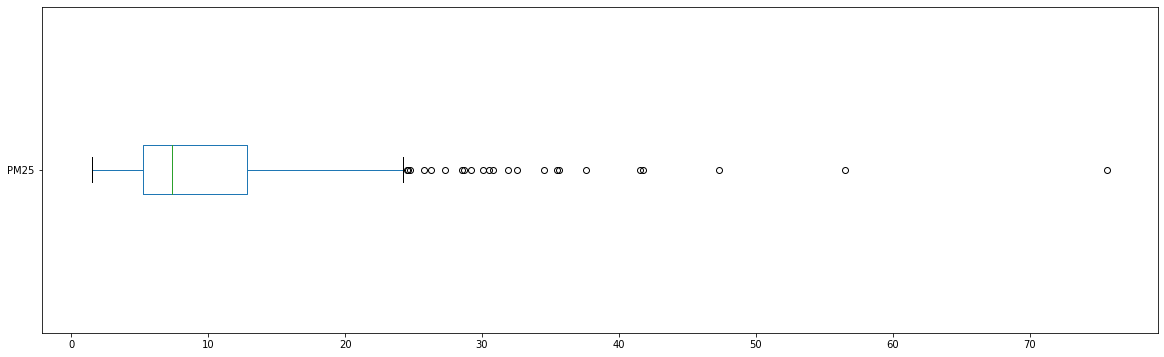

In [14]:
plt.figure(figsize=(20,6))
pre_covid_df[[COMPONENT]].boxplot(vert=False)
plt.grid(False)

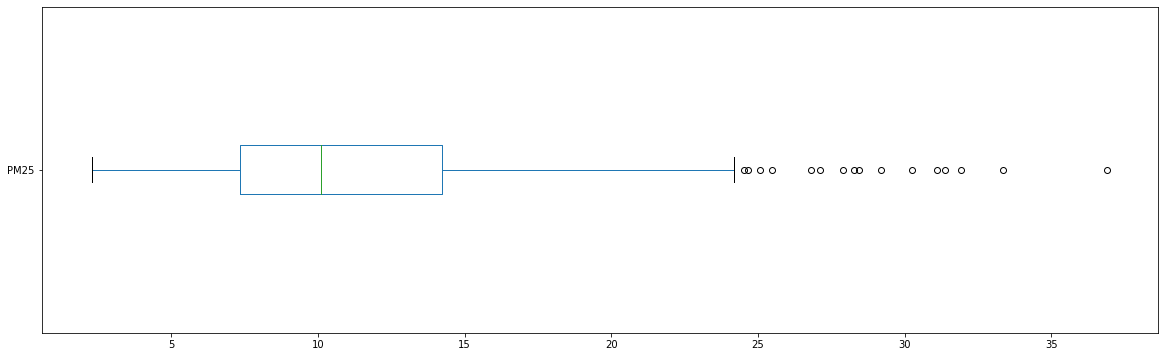

In [15]:
plt.figure(figsize=(20,6))
after_covid_df[[COMPONENT]].boxplot(vert=False)
plt.grid(False)

In [16]:
print('Pre covid outlier:')
print(pre_covid_df[pre_covid_df[COMPONENT] > 70][[COMPONENT]])
print('')
print('After covid outlier:')
print(after_covid_df[after_covid_df[COMPONENT] > 35][[COMPONENT]])

Pre covid outlier:
component_id                    PM25
timestamp_measured                  
2020-01-01 00:00:00+00:00  75.641667

After covid outlier:
component_id                  PM25
timestamp_measured                
2021-03-03 00:00:00+00:00  36.8875


Seems like on 2020 the outlier is due to the new year's, however, in the 2021 dataset we no longer have this outlier, this can be attributed to most of Europe having major restrictions at the time.
On further iterations of the model, if we go back to 'normal' times, the effect of new year's will need to be studied, to decide wether we want to remove it or not.

Another major festivity held in the Netherlands is called 'King's day', taking place on the 27th of April every year. Do we see any major shift?

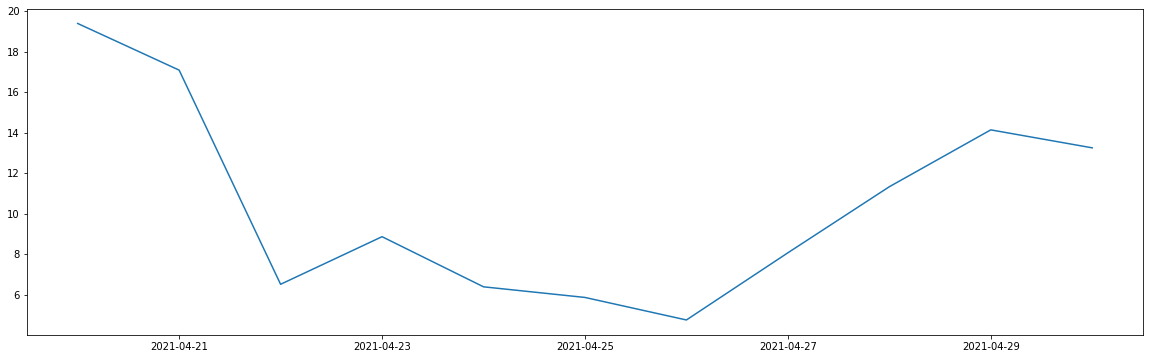

In [17]:
start = '2021-04-20'
end = '2021-04-30'
plt.figure(figsize=(20,6))
plt.plot(pivot_df[start:end].index, pivot_df[COMPONENT][start:end])
plt.show()

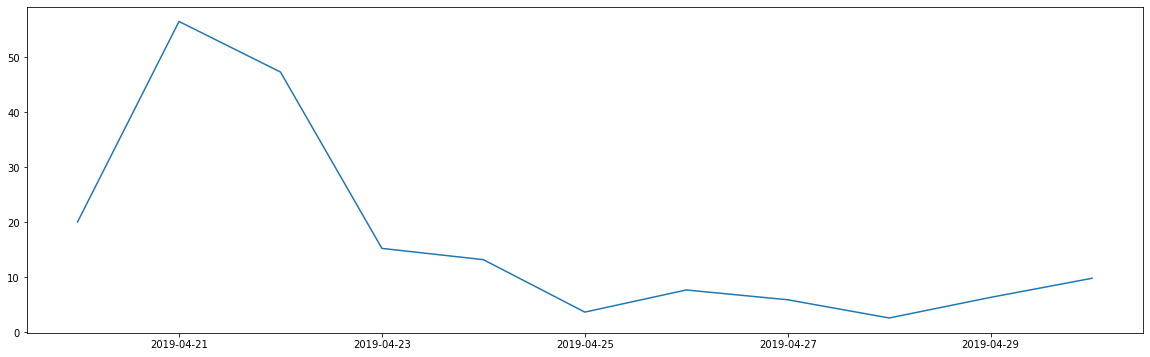

In [18]:
start = '2019-04-20'
end = '2019-04-30'
plt.figure(figsize=(20,6))
plt.plot(pivot_df[start:end].index, pivot_df[COMPONENT][start:end])
plt.show()

Seems like in both cases there isn't any significant shift in the PM25 particle.

Now let's see if we can find any trend in our pre or post covid datasets

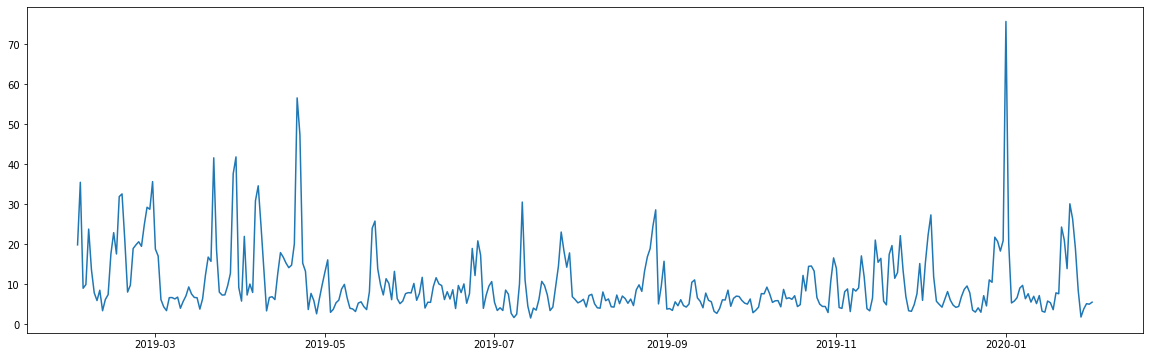

In [19]:
plt.figure(figsize=(20,6))
plt.plot(pre_covid_df.index, pre_covid_df[COMPONENT])
plt.show()

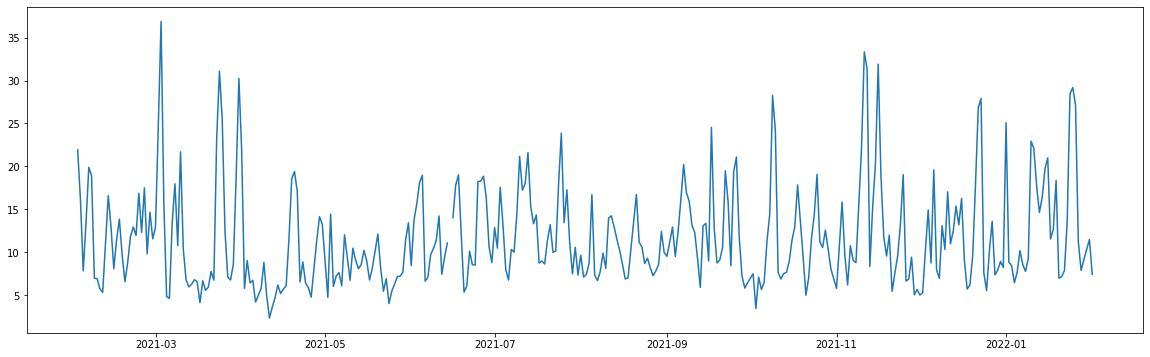

In [20]:
plt.figure(figsize=(20,6))
plt.plot(after_covid_df.index, after_covid_df[COMPONENT])
plt.show()

Seems like looking at our dataset with just the days doesn't give us much information, let's try adding the seasons.

In [21]:
pre_covid_winter = pivot_df.loc[pivot_df['season'] == 'winter'][pre_covid_date_start: pre_covid_date_end]
pre_covid_spring = pivot_df.loc[pivot_df['season'] == 'spring'][pre_covid_date_start: pre_covid_date_end]
pre_covid_summer = pivot_df.loc[pivot_df['season'] == 'summer'][pre_covid_date_start: pre_covid_date_end]
pre_covid_autumn = pivot_df.loc[pivot_df['season'] == 'autumn'][pre_covid_date_start: pre_covid_date_end]

after_covid_winter = pivot_df.loc[pivot_df['season'] == 'winter'][after_covid_date_start: after_covid_date_end]
after_covid_spring = pivot_df.loc[pivot_df['season'] == 'spring'][after_covid_date_start: after_covid_date_end]
after_covid_summer = pivot_df.loc[pivot_df['season'] == 'summer'][after_covid_date_start: after_covid_date_end]
after_covid_autumn = pivot_df.loc[pivot_df['season'] == 'autumn'][after_covid_date_start: after_covid_date_end]

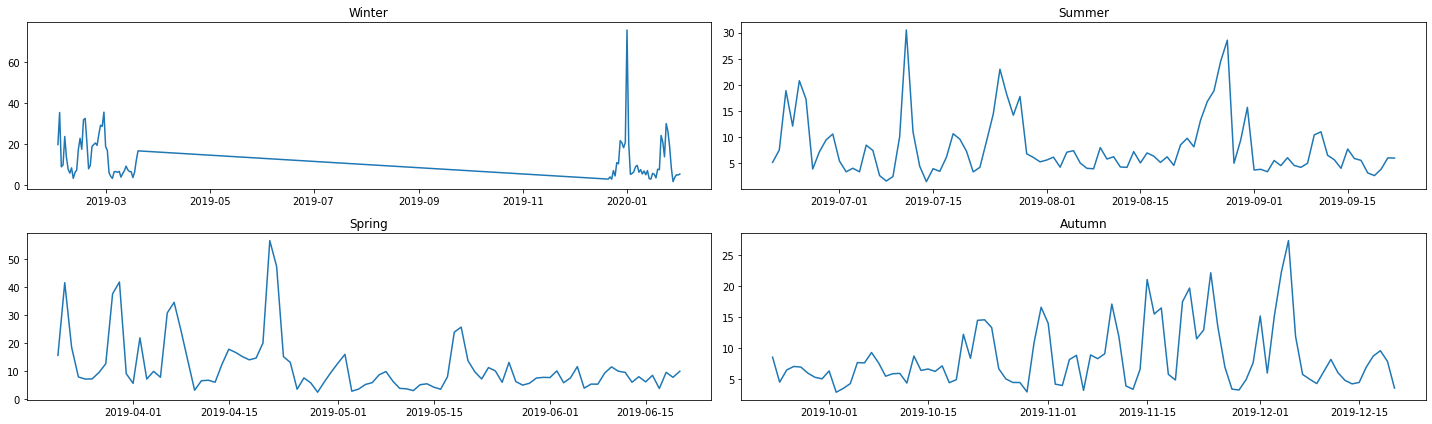

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(20,6))
axs[0, 0].plot(pre_covid_winter.index, pre_covid_winter[COMPONENT])
axs[0, 0].set_title("Winter")
axs[1, 0].plot(pre_covid_spring.index, pre_covid_spring[COMPONENT])
axs[1, 0].set_title("Spring")
axs[0, 1].plot(pre_covid_summer.index, pre_covid_summer[COMPONENT])
axs[0, 1].set_title("Summer")
axs[1, 1].plot(pre_covid_autumn.index, pre_covid_autumn[COMPONENT])
axs[1, 1].set_title("Autumn")
fig.tight_layout()

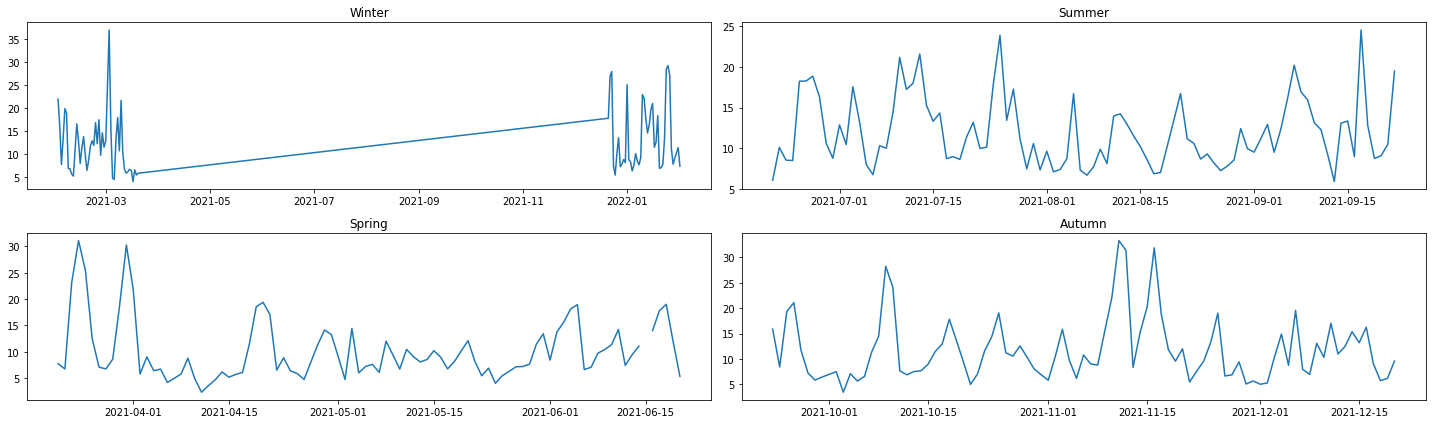

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(20,6))
axs[0, 0].plot(after_covid_winter.index, after_covid_winter[COMPONENT])
axs[0, 0].set_title("Winter")
axs[1, 0].plot(after_covid_spring.index, after_covid_spring[COMPONENT])
axs[1, 0].set_title("Spring")
axs[0, 1].plot(after_covid_summer.index, after_covid_summer[COMPONENT])
axs[0, 1].set_title("Summer")
axs[1, 1].plot(after_covid_autumn.index, after_covid_autumn[COMPONENT])
axs[1, 1].set_title("Autumn")
fig.tight_layout()


Our first observation is that pre covid values are much higher than post covid. This leads us to decide that we will not use pre covid values on our model for now. If there is ever a time we return to values similar to pre covid ones we can add them back.


In general, after 2020, concentration values for PM2.5 have decreased, with Winter being the season where we notice the biggest change, this is probably due to some lockdown policies still in effect in the Netherlands around this time. 

## How does Stadhouderskade compare with the other streets of Amsterdam?

For this analysis, besides the sensor for Stadhouderskade, we considered seven other sensors set up in the center of Amsterdam. We're using air quality for all the sensors in the Netherlands which also contains some metadata about the stations such as:
* Station name
* Type of station (traffic or background)
* Longitude and latitude coordinates

The type of station will be useful for the analysis we will carry, in order to compare Stadhouderskade with other stations.

In [24]:
ams_sensors = ["NL49007", "NL49017", "NL49002", "NL49014", "NL49012", "NL49003", "NL49019", "NL49020"]

In [25]:
metadata = pd.read_csv(join(data_directory, '2021_NO.csv'), nrows=7, encoding='latin-1', delimiter=';')
metadata

,Datum export,20210928 09:58,Unnamed: 2,Unnamed: 3,StationsCode,NL01485,NL01487,NL01488,NL01489,NL01491,...,NL49546,NL49551,NL49553,NL49561,NL49564,NL49565,NL49701,NL49703,NL49704,Unnamed: 78
0,Periode,20210101 00:00 - 20210201 00:00,NaN,NaN,Stationsnaam,Hoogvliet-Leemkuil,Rotterdam Zuid-Pleinweg,Rotterdam Zuid-Zwartewaalstraat,Ridderkerk-Hogeweg,Rotterdam-Oost Sidelinge A13,...,Zaanstad-Hemkade,IJmuiden-Kanaaldijk,Wijk aan Zee-Burgemeester Rothestraat,Badhoevedorp-Sloterweg,Hoofddorp-Hoofdweg,Oude Meer-Aalsmeerderdijk,Zaandam-Wagenschotpad,Amsterdam-Spaarnwoude,Amsterdam-Hoogtij,NaN
1,Bron,https://data.rivm.nl/data/luchtmeetnet,NaN,NaN,"Latitude,Longitude","(51.867411,4.355242)","(51.891147,4.48069)","(51.893617,4.487528)","(51.869431,4.580058)","(51.938472,4.430692)",...,"(52.42023,4.83206)","(52.463039,4.601842)","(52.493992,4.601986)","(52.334003,4.774006)","(52.327464,4.715008)","(52.279991,4.770773)","(52.448011,4.816706)","(52.398437,4.728581)","(52.428017,4.773478)",NaN
2,Beschrijving data,https://data.rivm.nl/data/luchtmeetnet/readme.pdf,NaN,NaN,Stationsgebied,stad,stad,stad,stad,stad,...,stad,stad,stad,stad,onbekend,regionaal,stad,regionaal,stad,NaN
3,NaN,NaN,NaN,NaN,Stationstype,achtergrond,verkeer,achtergrond,verkeer,verkeer,...,industrie,industrie,industrie,achtergrond,onbekend,achtergrond,achtergrond,achtergrond,industrie,NaN
4,NaN,NaN,NaN,NaN,Meetprincipe,Chemiluminescentie,Chemiluminescentie,Chemiluminescentie,Chemiluminescentie,Chemiluminescentie,...,Chemiluminescentie,Chemiluminescentie,Chemiluminescentie,Chemiluminescentie,Chemiluminescentie,Chemiluminescentie,Chemiluminescentie,Chemiluminescentie,Chemiluminescentie,NaN
5,NaN,NaN,NaN,NaN,Meetopstelling,Teledyne API 200E chemiluminescent Nox Analyser,Teledyne API 200E chemiluminescent Nox Analyser,Teledyne API 200E chemiluminescent Nox Analyser,Teledyne API 200E chemiluminescent Nox Analyser,Teledyne API 200E chemiluminescent Nox Analyser,...,Teledyne API 200E chemiluminescent Nox Analyser,Teledyne API 200E chemiluminescent Nox Analyser,Teledyne API 200E chemiluminescent Nox Analyser,Teledyne API 200E chemiluminescent Nox Analyser,Teledyne API 200E chemiluminescent Nox Analyser,Teledyne API 200E chemiluminescent Nox Analyser,Thermo model 42w NO/Nox analyser,Teledyne API 200E chemiluminescent Nox Analyser,Teledyne API 200E chemiluminescent Nox Analyser,NaN
6,Component,Bep.periode,Eenheid,Begindatumtijd,Einddatumtijd,NL01485,NL01487,NL01488,NL01489,NL01491,...,NL49546,NL49551,NL49553,NL49561,NL49564,NL49565,NL49701,NL49703,NL49704,NaN


In [26]:
metadata_melt_street = metadata.loc[0:1].melt(id_vars=["StationsCode"], value_vars=ams_sensors, var_name="Sensor", value_name="Station Name")
metadata_melt_street = metadata_melt_street[metadata_melt_street["StationsCode"] == "Stationsnaam"]
metadata_melt_street = metadata_melt_street.drop(["StationsCode"], axis=1)

In [27]:
metadata_melt_type = metadata.loc[0:3].melt(id_vars=["StationsCode"], value_vars=ams_sensors, var_name="Sensor", value_name="Station Type")
metadata_melt_type = metadata_melt_type[metadata_melt_type["StationsCode"] == "Stationstype"]
metadata_melt_type = metadata_melt_type.drop(["StationsCode"], axis=1)
metadata_melt_type["Station Type"] = metadata_melt_type["Station Type"].map({"verkeer": "Traffic", "achtergrond": "Background"})

In [28]:
metadata_melt_street["Station Name"] = metadata_melt_street["Station Name"].apply(lambda x: x.replace("Amsterdam-", ""))

In [29]:
metadata_melt = metadata.loc[0:1].melt(id_vars=["StationsCode"], value_vars=ams_sensors, var_name="Sensor", value_name="LATLONG")
metadata_melt_latlon = metadata_melt[metadata_melt["StationsCode"] == "Latitude,Longitude"]
metadata_melt_latlon = metadata_melt_latlon.drop(["StationsCode"], axis=1)

In [30]:
metadata_melt_latlon["Longitude"] = metadata_melt_latlon["LATLONG"].apply(lambda x: float(x.split(",")[1].replace(")", "")))
metadata_melt_latlon["Latitude"] = metadata_melt_latlon["LATLONG"].apply(lambda x: float(x.split(",")[0].replace("(", "")))
metadata_melt_latlon = metadata_melt_latlon.drop(columns=["LATLONG"])

In [31]:
metadata_final = metadata_melt_street.merge(metadata_melt_latlon, how="inner", on="Sensor")
metadata_final = metadata_final.merge(metadata_melt_type, on="Sensor")
metadata_final

,Sensor,Station Name,Longitude,Latitude,Station Type
0,NL49007,Einsteinweg,4.845233,52.381331,Traffic
1,NL49017,Stadhouderskade,4.899700,52.358039,Traffic
2,NL49002,Haarlemmerweg,4.875750,52.385422,Traffic
3,NL49014,Vondelpark,4.866208,52.359714,Background
4,NL49012,Van Diemenstraat,4.887811,52.389983,Traffic
5,NL49003,Nieuwendammerdijk,4.943822,52.389314,Background
6,NL49019,Oude Schans,4.904400,52.372056,Background
7,NL49020,Jan van Galenstraat,4.860319,52.374786,Traffic


In [32]:
ams_start_coordinates = [52.3676, 4.9041]
factor = 7.3
ams_map = folium.Map(location=ams_start_coordinates, zoom_start=13, control_scale=True)
for lat, lon, sensor, name, sens_type in zip(metadata_final["Latitude"], metadata_final["Longitude"], metadata_final["Sensor"], metadata_final["Station Name"], metadata_final["Station Type"]):
    marker = folium.Marker(location=[lat, lon], tooltip=sensor + "-" + name)
    ams_map.add_child(marker)
    text = sensor + " - " + name + " - " + sens_type
    icon_size_x = len(text) * factor
    text_marker = folium.map.Marker(   
        [lat, lon],
        icon=DivIcon(
            icon_size=(icon_size_x, 10),
            icon_anchor=(0, 0),
            html='<div style="background: #fff; font-size: 10pt">%s</div>' % text,
        )
    )
    ams_map.add_child(text_marker)
ams_map

Mapping out our sensors we get this distribution, the traffic sensors are easy to identify as they are usually near high traffic areas.

In [33]:
components = ["NO2", "PM10", "PM25"]
traffic_sensors = ["Stadhouderskade", "NL49007", "NL49002", "NL49012", "NL49020"]
background_sensors = ["Stadhouderskade", "NL49014", "NL49003", "NL49019"]
over_limit_traffic = [f'over_limit_{sensor}' for sensor in traffic_sensors]
over_limit_background = [f'over_limit_{sensor}' for sensor in background_sensors]

Below we're reading datasets to aggregate air quality data for all the sensors in the Netherlands for years 2018 to 2021 for components NO, NO2, PM10 and PM25.

In [34]:
all_streets_path = join(realpath(data_directory), "datasets_all_streets")
years = [2018, 2019, 2020, 2021]

In [35]:
all_csvs = pd.DataFrame()

for year in years:
    csv_files = [
        pos_json for pos_json in listdir(join(all_streets_path, str(year)))
        if pos_json.endswith('.csv')
    ]
    for file in csv_files:
        df = pd.read_csv(join(all_streets_path, str(year), file), skiprows=7, encoding='latin-1', delimiter=';')
        all_csvs = pd.concat([all_csvs, df])

In [36]:
dataset = all_csvs.copy(deep=True)
dataset.tail(2)

,Component,Bep.periode,Eenheid,Begindatumtijd,Einddatumtijd,NL01437,NL01487,NL01488,NL01491,NL01492,...,NL50007,NL50009,NL54010,NL01484,NL10449,NL01913,Unnamed: 78,NL49557,Unnamed: 55,Unnamed: 74
8758,PM10,uur,µg/m³,20211231 22:00,20211231 23:00,NaN,45.1,35.7,28.9,NaN,...,NaN,NaN,NaN,NaN,65.87,29.2,NaN,22.0,NaN,19.9
8759,PM10,uur,µg/m³,20211231 23:00,20220101 00:00,NaN,43.7,40.4,29.4,NaN,...,NaN,NaN,NaN,NaN,96.59,31.6,NaN,27.0,NaN,21.9


In [37]:
dataset["start_datetime"] = pd.to_datetime(dataset["Begindatumtijd"])
dataset["end_datetime"] = pd.to_datetime(dataset["Einddatumtijd"])

In [38]:
columns_analysis = ams_sensors + ["start_datetime", "year", "Component"]

In [39]:
dataset["year"] = dataset["start_datetime"].apply(lambda x: x.year)

In [40]:
dataset["Component"] = dataset["Component"].apply(lambda x: x.replace("PM2.5", "PM25"))

In [41]:
dataset_filtered = dataset[columns_analysis]
dataset_filtered.tail(2)

,NL49007,NL49017,NL49002,NL49014,NL49012,NL49003,NL49019,NL49020,start_datetime,year,Component
8758,33.87,30.0,NaN,42.1,27.1,NaN,NaN,28.6,2021-12-31 22:00:00,2021,PM10
8759,44.11,26.9,NaN,29.5,26.9,NaN,NaN,32.7,2021-12-31 23:00:00,2021,PM10


In [42]:
dataset_filtered_components = dataset_filtered[dataset_filtered["Component"].isin(components)]

In [43]:
dataset_filtered_components = dataset_filtered_components.rename(columns={"NL49017": "Stadhouderskade"})
dataset_filtered_components = dataset_filtered_components.set_index('start_datetime')
dataset_filtered_components = dataset_filtered_components.sort_index()

### Continuing our analysis for PM2.5 

We will compare the presence of this component between stations tagged as traffic and stations tagged as background.

Given that our goal is to make the street more walkable, this analysis should be used as a talking point about what our end goal is.

In [44]:
dataset_pm25 = dataset_filtered_components[dataset_filtered_components["Component"] == COMPONENT]

In [45]:
dataset_pm25_year = dataset_pm25.resample("Y").mean()

**Stadhouderskade VS Traffic stations**

Text(0, 0.5, 'Mean Component')

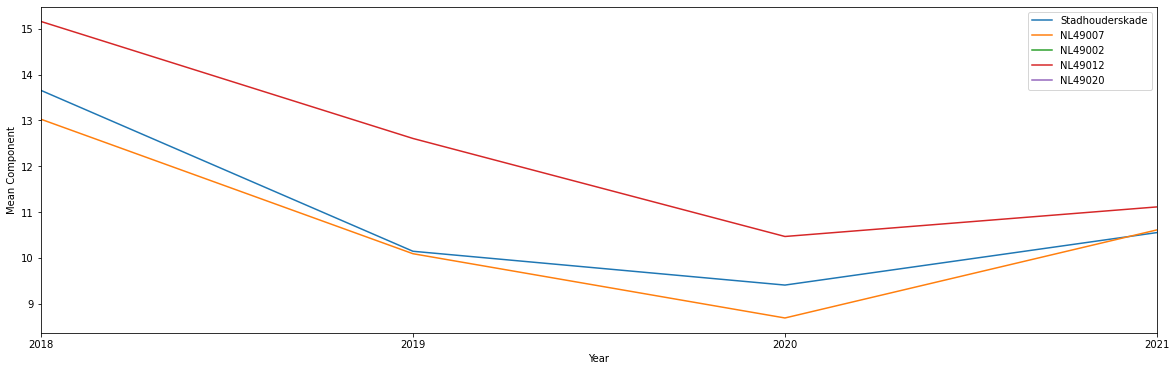

In [46]:
ax = dataset_pm25_year[traffic_sensors].plot(figsize=(20, 6))
ax.set_xlabel("Year")
ax.set_ylabel("Mean Component")

**Stadhouderskade VS Background stations**

Text(0, 0.5, 'Mean Component')

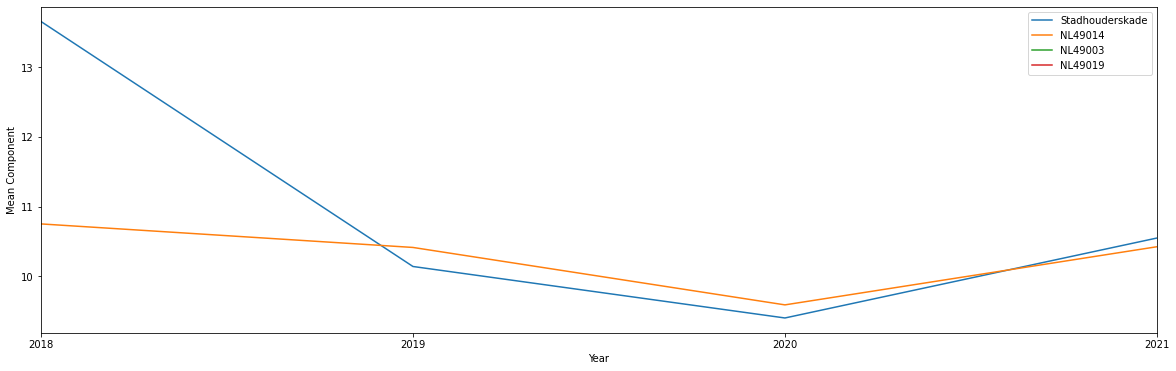

In [47]:
ax = dataset_pm25_year[background_sensors].plot(figsize=(20, 6))
ax.set_xlabel("Year")
ax.set_ylabel("Mean Component")

#### Over limit 
According to [Luchtmeet](https://www.luchtmeetnet.nl/informatie/componenten/fijn-stof-(pm2.5)), the annual reference value for PM2.5 is 25 microgram per cubic meter. 

In [48]:
dataset_pm25_day = dataset_pm25.resample("D").mean()
limit = 25

for sensor in traffic_sensors + background_sensors:
    dataset_pm25_day[f'over_limit_{sensor}'] = 0
    dataset_pm25_day.loc[dataset_pm25_day[sensor] > limit, f'over_limit_{sensor}'] = 1

dataset_pm25_month = dataset_pm25_day[over_limit_background + over_limit_traffic].resample("M").sum()

**Stadhouderskade VS Traffic stations**

Text(0, 0.5, 'Mean Component')

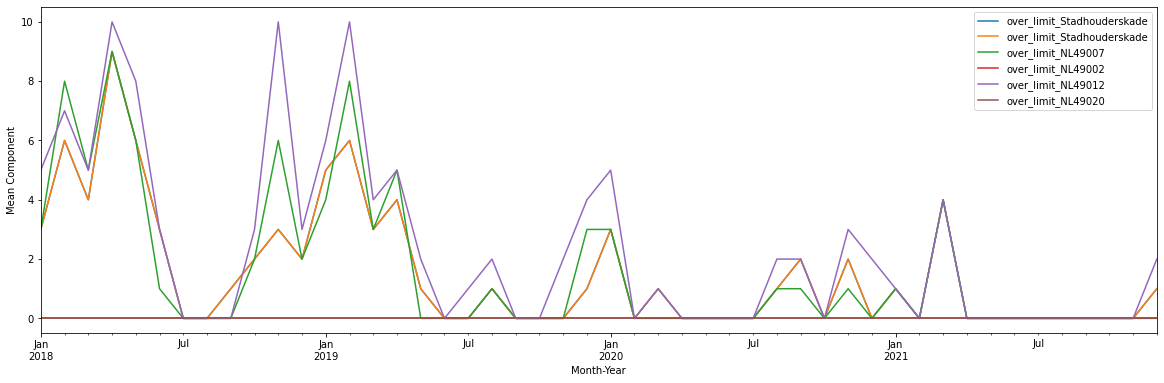

In [49]:
ax = dataset_pm25_month[over_limit_traffic].plot(figsize=(20, 6))
ax.set_xlabel("Month-Year")
ax.set_ylabel("Mean Component")

**Stadhouderskade VS Background stations**

Text(0, 0.5, 'Mean Component')

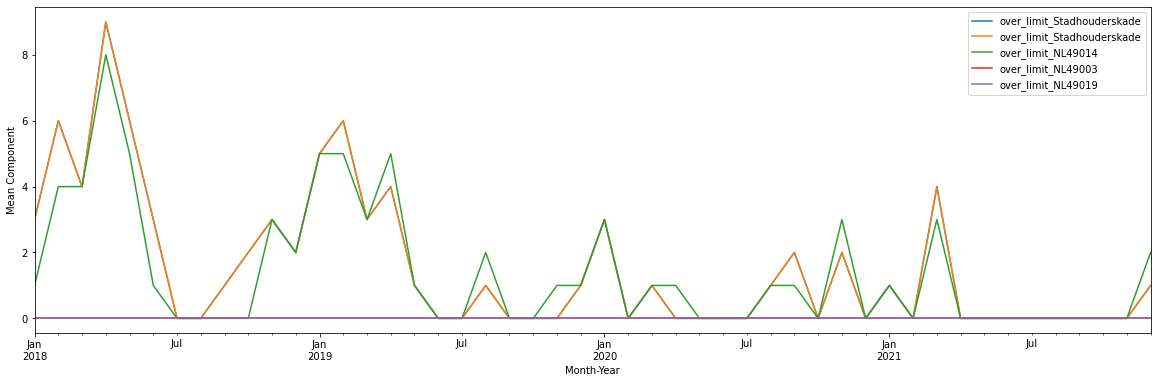

In [50]:
ax = dataset_pm25_month[over_limit_background].plot(figsize=(20, 6))
ax.set_xlabel("Month-Year")
ax.set_ylabel("Mean Component")

## Back to our main analysis on Stadhouderskade street

### Explore stationarity, moving averages and lagged values

### Stationarity

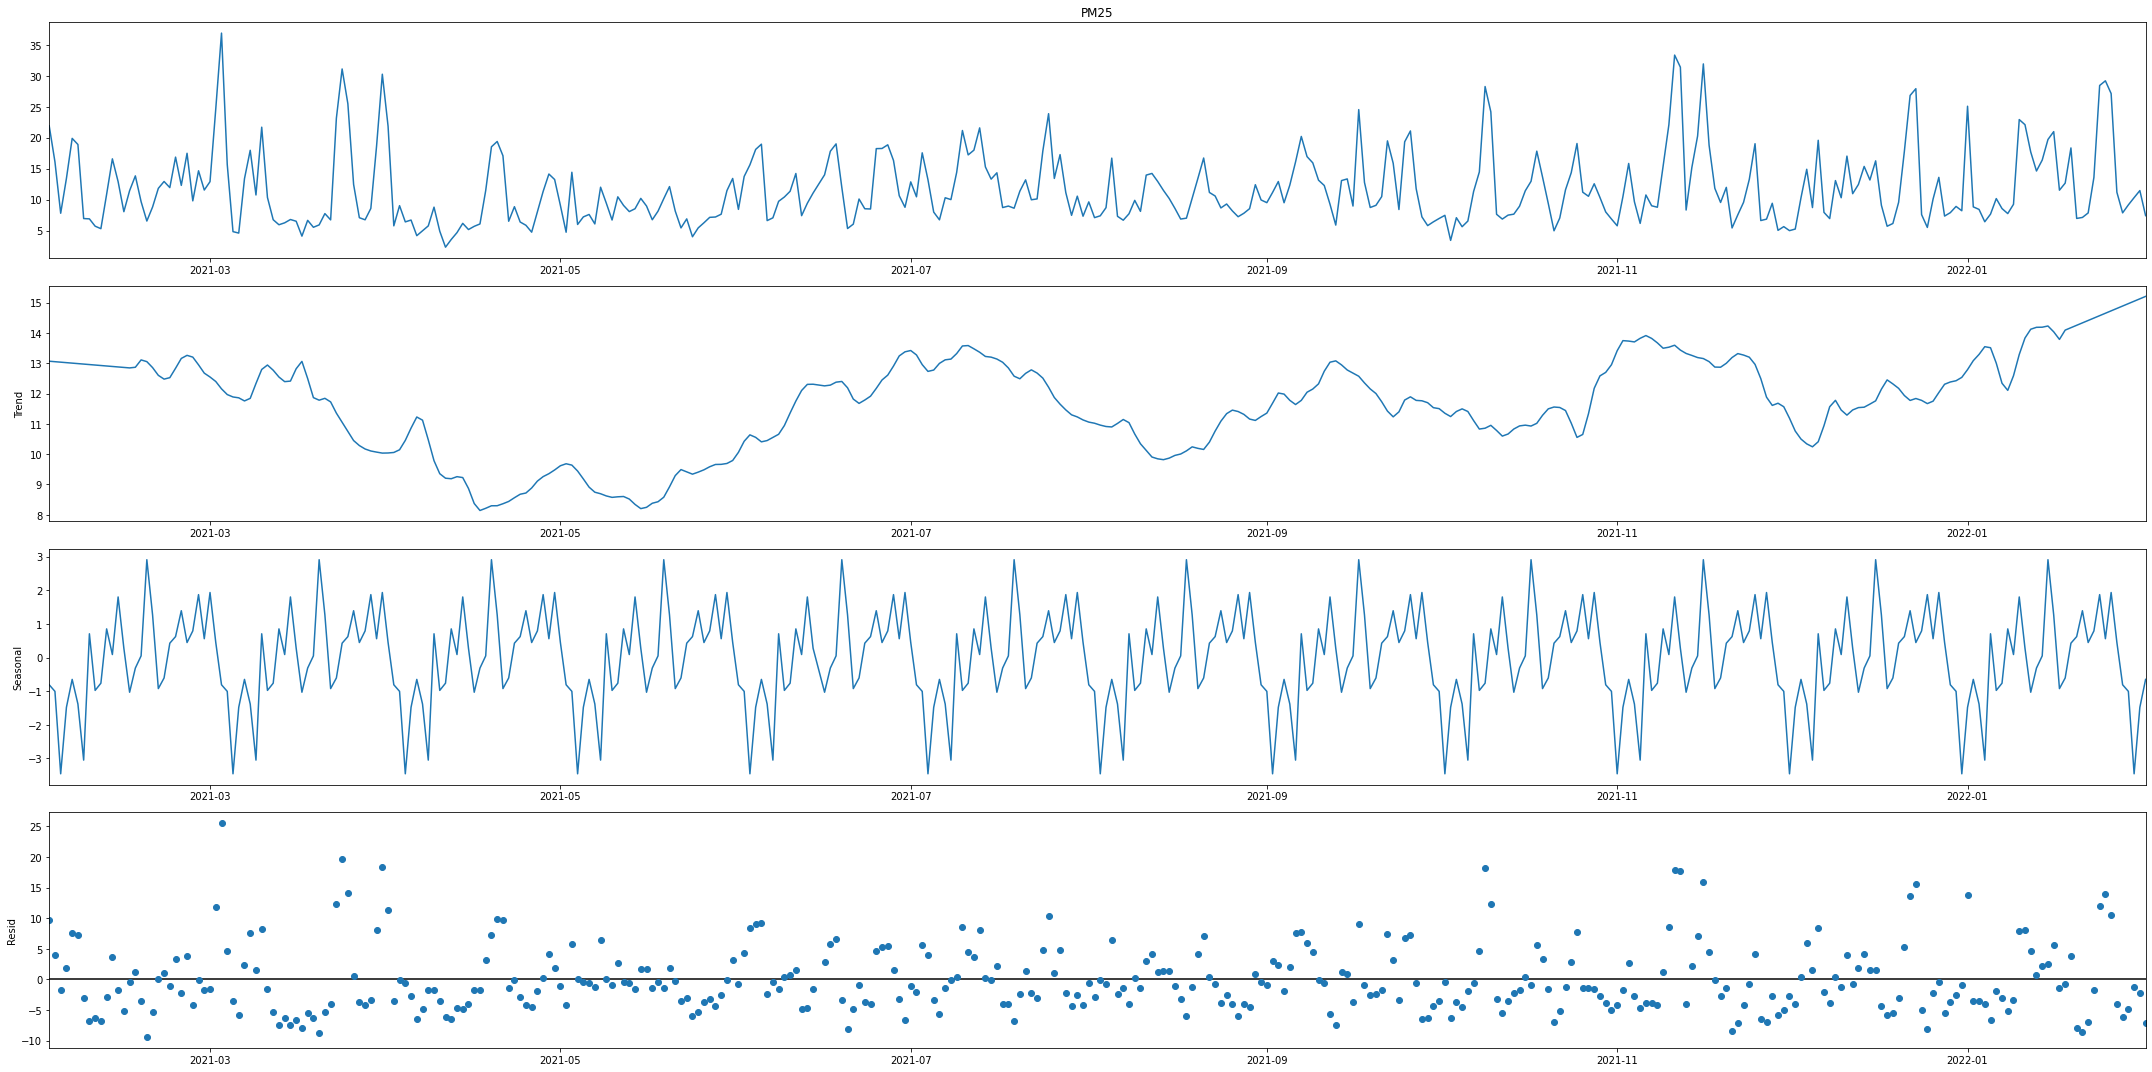

In [51]:
plt.rcParams['figure.figsize'] = (30, 15)
result = seasonal_decompose(after_covid_df[COMPONENT].dropna(), extrapolate_trend='freq', period=30) 
result.plot()
plt.show()

To ensure we can model this data we also have to run the adfuller test, if the output is that the data is stationary then we don't need to apply any transformation

In [52]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(after_covid_df[COMPONENT].dropna())
if pval < 0.05:
    print('Data is stationary')

Data is stationary


### Computing moving averages

In [53]:
pivot_df = pivot_df['2021-01-01': '2022-03-01']
moving_avg_7_days = pivot_df.rolling(7, min_periods=0).mean()
moving_avg_5_days = pivot_df.rolling(5, min_periods=0).mean()
moving_avg_3_days = pivot_df.rolling(3, min_periods=0).mean()
moving_avg_2_days = pivot_df.rolling(2, min_periods=0).mean()

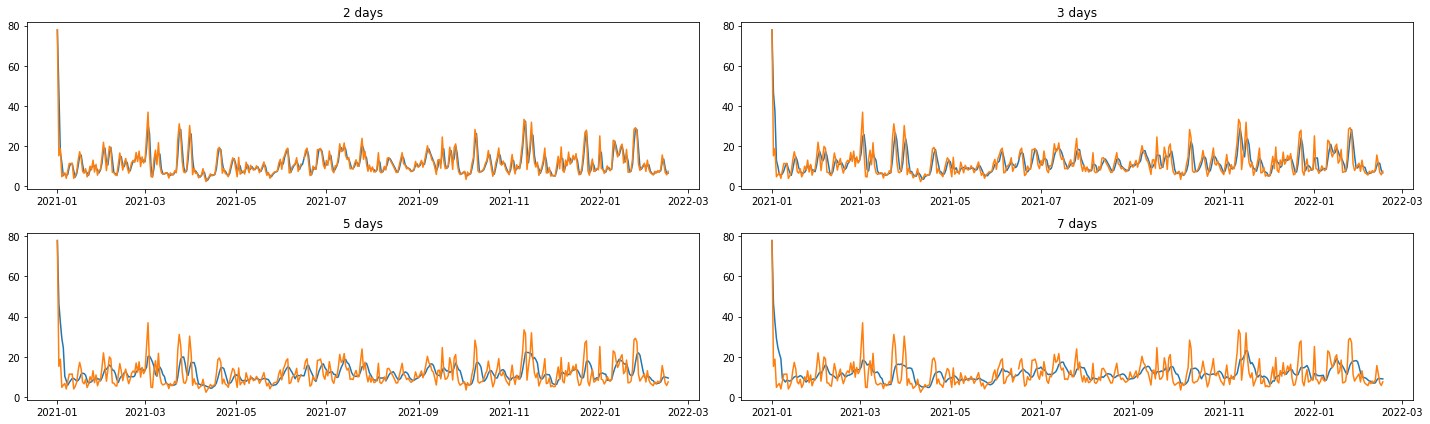

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(20,6))
axs[0, 0].plot(moving_avg_2_days.index, moving_avg_2_days[COMPONENT])
axs[0, 0].plot(pivot_df.index, pivot_df[COMPONENT])
axs[0, 0].set_title("2 days")
axs[0, 1].plot(moving_avg_3_days.index, moving_avg_3_days[COMPONENT])
axs[0, 1].plot(pivot_df.index, pivot_df[COMPONENT])
axs[0, 1].set_title("3 days")
axs[1, 0].plot(moving_avg_5_days.index, moving_avg_5_days[COMPONENT])
axs[1, 0].plot(pivot_df.index, pivot_df[COMPONENT])
axs[1, 0].set_title("5 days")
axs[1, 1].plot(moving_avg_7_days.index, moving_avg_7_days[COMPONENT])
axs[1, 1].plot(pivot_df.index, pivot_df[COMPONENT])
axs[1, 1].set_title("7 days")
fig.tight_layout()

Analysing the output graphs from the moving averages it seems like we would benefit more from having a moving average of two days as an input feature, but since the three days moving average also looks interesting, we will keep both and analyse their correlation to the target variable.

In [55]:
pivot_df = pivot_df.merge(moving_avg_3_days[all_components], left_index=True, right_index=True, suffixes=('', '_moving_3_days'))
pivot_df = pivot_df.merge(moving_avg_2_days[all_components], left_index=True, right_index=True, suffixes=('', '_moving_2_days'))

### Lagged values

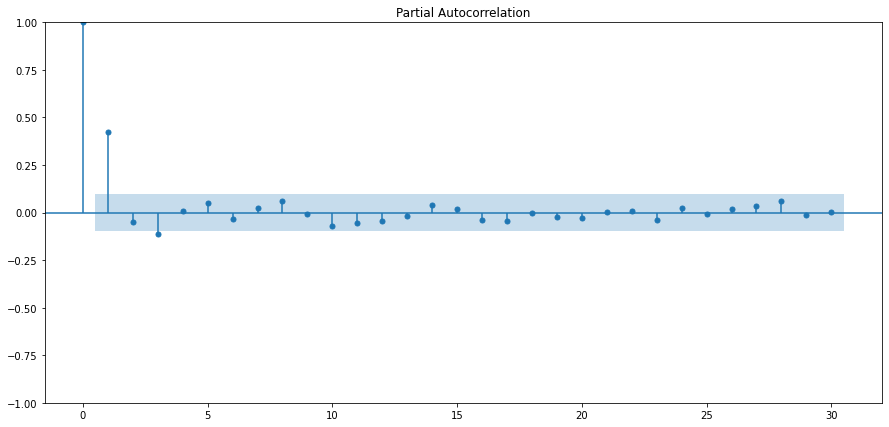

In [56]:
fig, ax = plt.subplots(figsize=(15,7))
plot_pacf(pivot_df[COMPONENT].dropna(), lags=30, ax=ax)
plt.show()

By checking the partial autocorrelation it looks like we would benefit from at least one lagged variable.

### Add weather data

In [57]:
pivot_df = pivot_df.merge(weather, left_on='date_of_measurement', right_index=True)

In [58]:
columns_to_lag =  ['C6H6', 'C7H8', 'C8H10', 'FN', 'NO', 'NO2', 'PM10', 'PM25']
lag_columns = ['C6H6_lagged', 'C7H8_lagged', 'C8H10_lagged', 'FN_lagged', 'NO_lagged', 'NO2_lagged', 'PM10_lagged', 'PM25_lagged']
moving_averages_columns = [ 'PM25_moving_3_days', 'PM10_moving_3_days', 'FN_moving_3_days', 'C8H10_moving_3_days', 'C7H8_moving_3_days', 
'C6H6_moving_3_days', 'NO2_moving_3_days', 'NO_moving_3_days', 'PM25_moving_2_days', 'PM10_moving_2_days', 'FN_moving_2_days',
'C8H10_moving_2_days', 'C7H8_moving_2_days', 'C6H6_moving_2_days', 'NO2_moving_2_days', 'NO_moving_2_days']
date_columns = ['day', 'month', 'year', 'month_year', 'weekday_number', 'is_weekend', 'weekday_written', 'week_of_year', 'day_of_year', 'is_holiday',
'season', 'is_winter', 'is_spring', 'is_summer', 'is_autumn', 'quarter']
weather_variables = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres']

In [59]:
pivot_copy = pivot_df.copy()
pivot_copy = pivot_copy[columns_to_lag]
pivot_copy.columns = lag_columns
pivot_lagged = pd.concat([pivot_df, pivot_copy.shift(1)], axis=1)
pivot_lagged.tail(1)

,C6H6,C7H8,C8H10,FN,NO,NO2,PM10,PM25,date_of_measurement,time_of_measurement,...,wpgt,pres,C6H6_lagged,C7H8_lagged,C8H10_lagged,FN_lagged,NO_lagged,NO2_lagged,PM10_lagged,PM25_lagged
timestamp_measured,,,,,,,,,,,,,,,,,,,,,
2022-02-16 00:00:00+00:00,0.314348,0.604783,0.391304,0.421739,6.06087,17.821739,11.456522,7.473913,2022-02-16,00:00:00,...,94.0,994.2,0.422609,0.792609,0.502609,0.545,8.391667,21.125,12.979167,5.695833


Having added our weather variables and our lagged variables, we will now check the correlation between them and the target value.

Since having all of the variables in one matrix would produce a huge matrix that would be hard to read, we have split this analysis between moving averages, lagged variables and weather variables.

### Correlation with moving averages

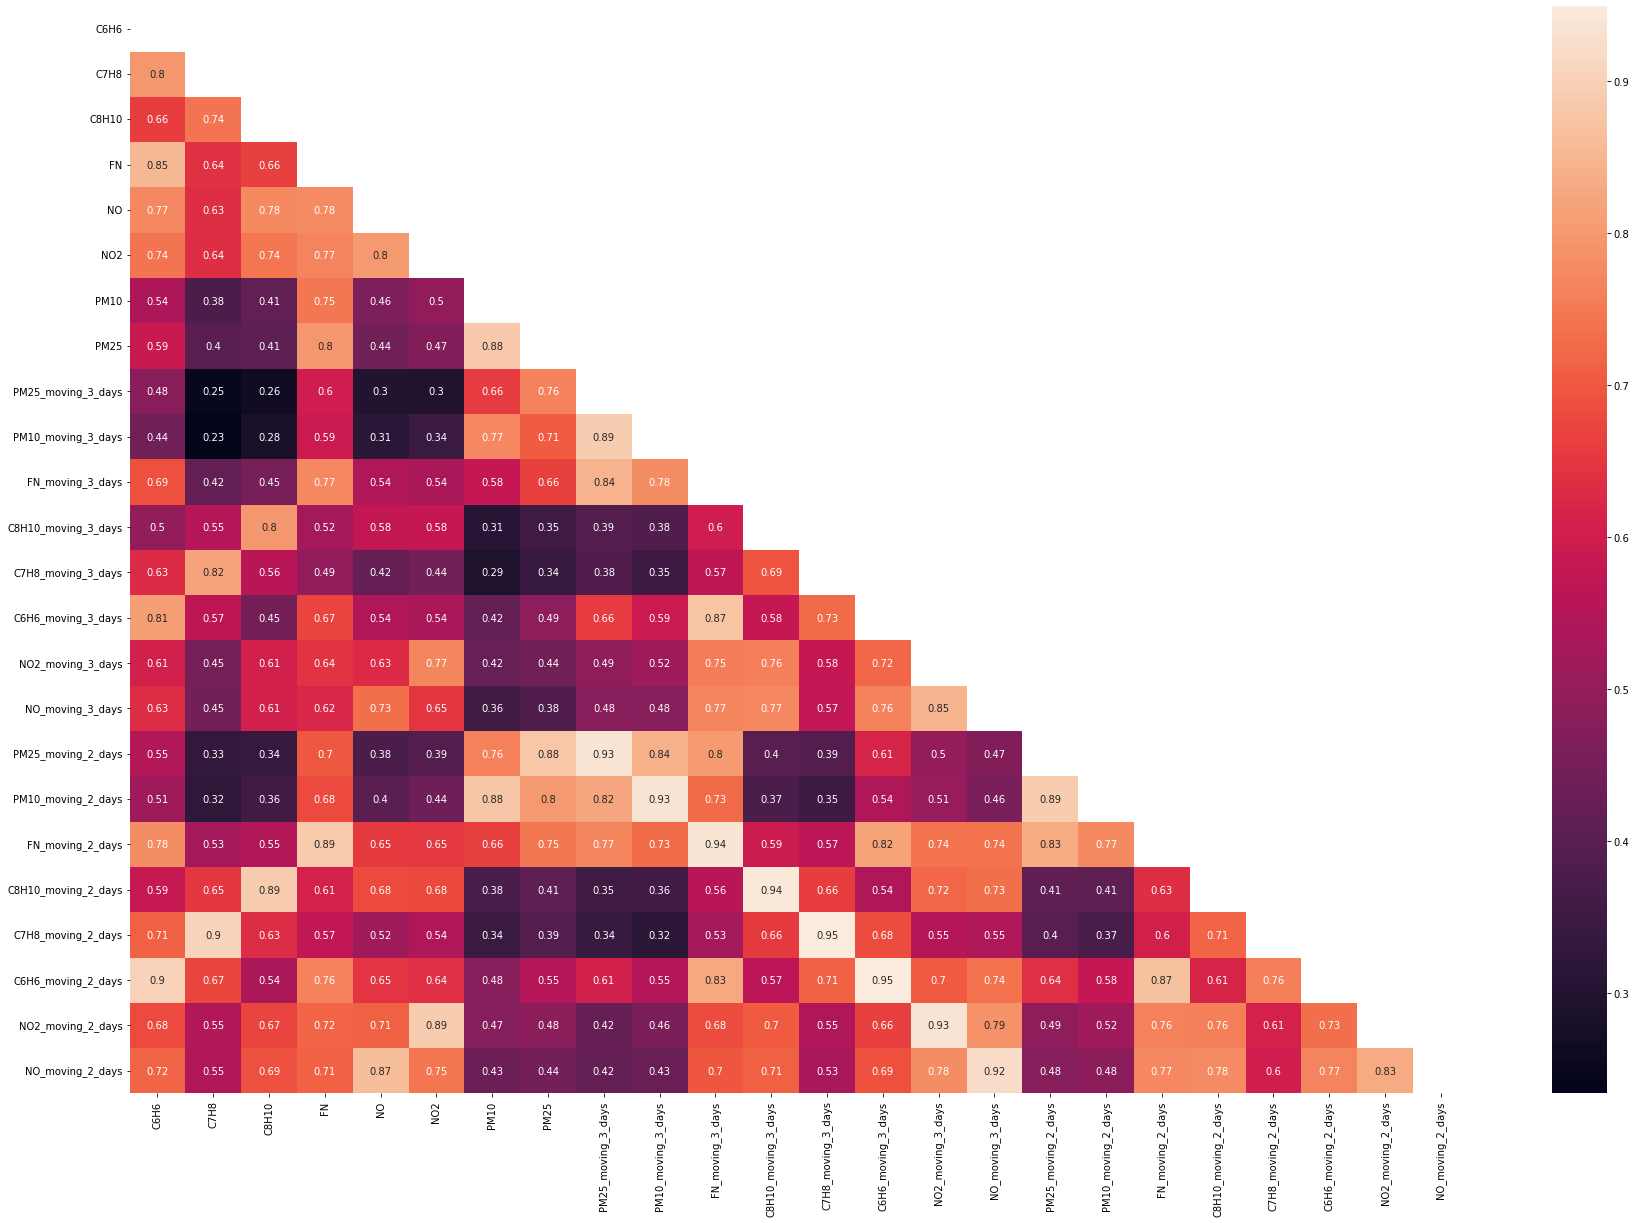

In [60]:
plt.figure(figsize=(30,20))

correlation = pivot_lagged[columns_to_lag + moving_averages_columns].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True)
plt.show()

### Correlation with weather

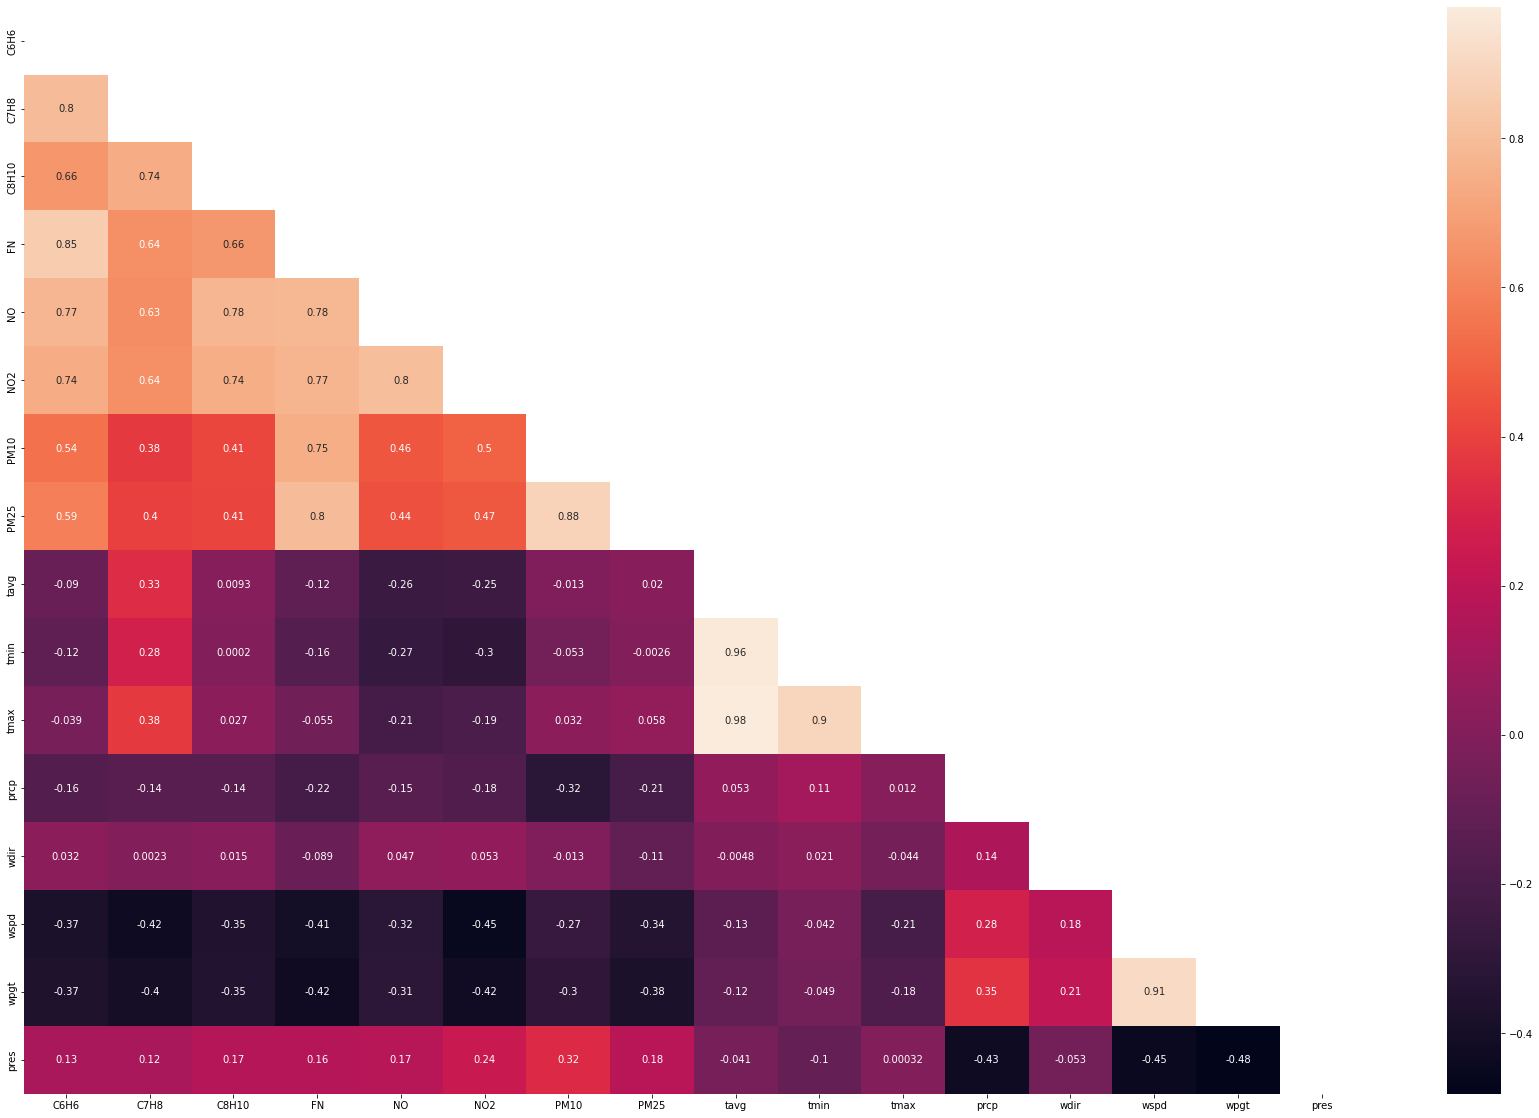

In [61]:
plt.figure(figsize=(30,20))

correlation = pivot_lagged[columns_to_lag + weather_variables].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True)
plt.show()

### Correlation with dates

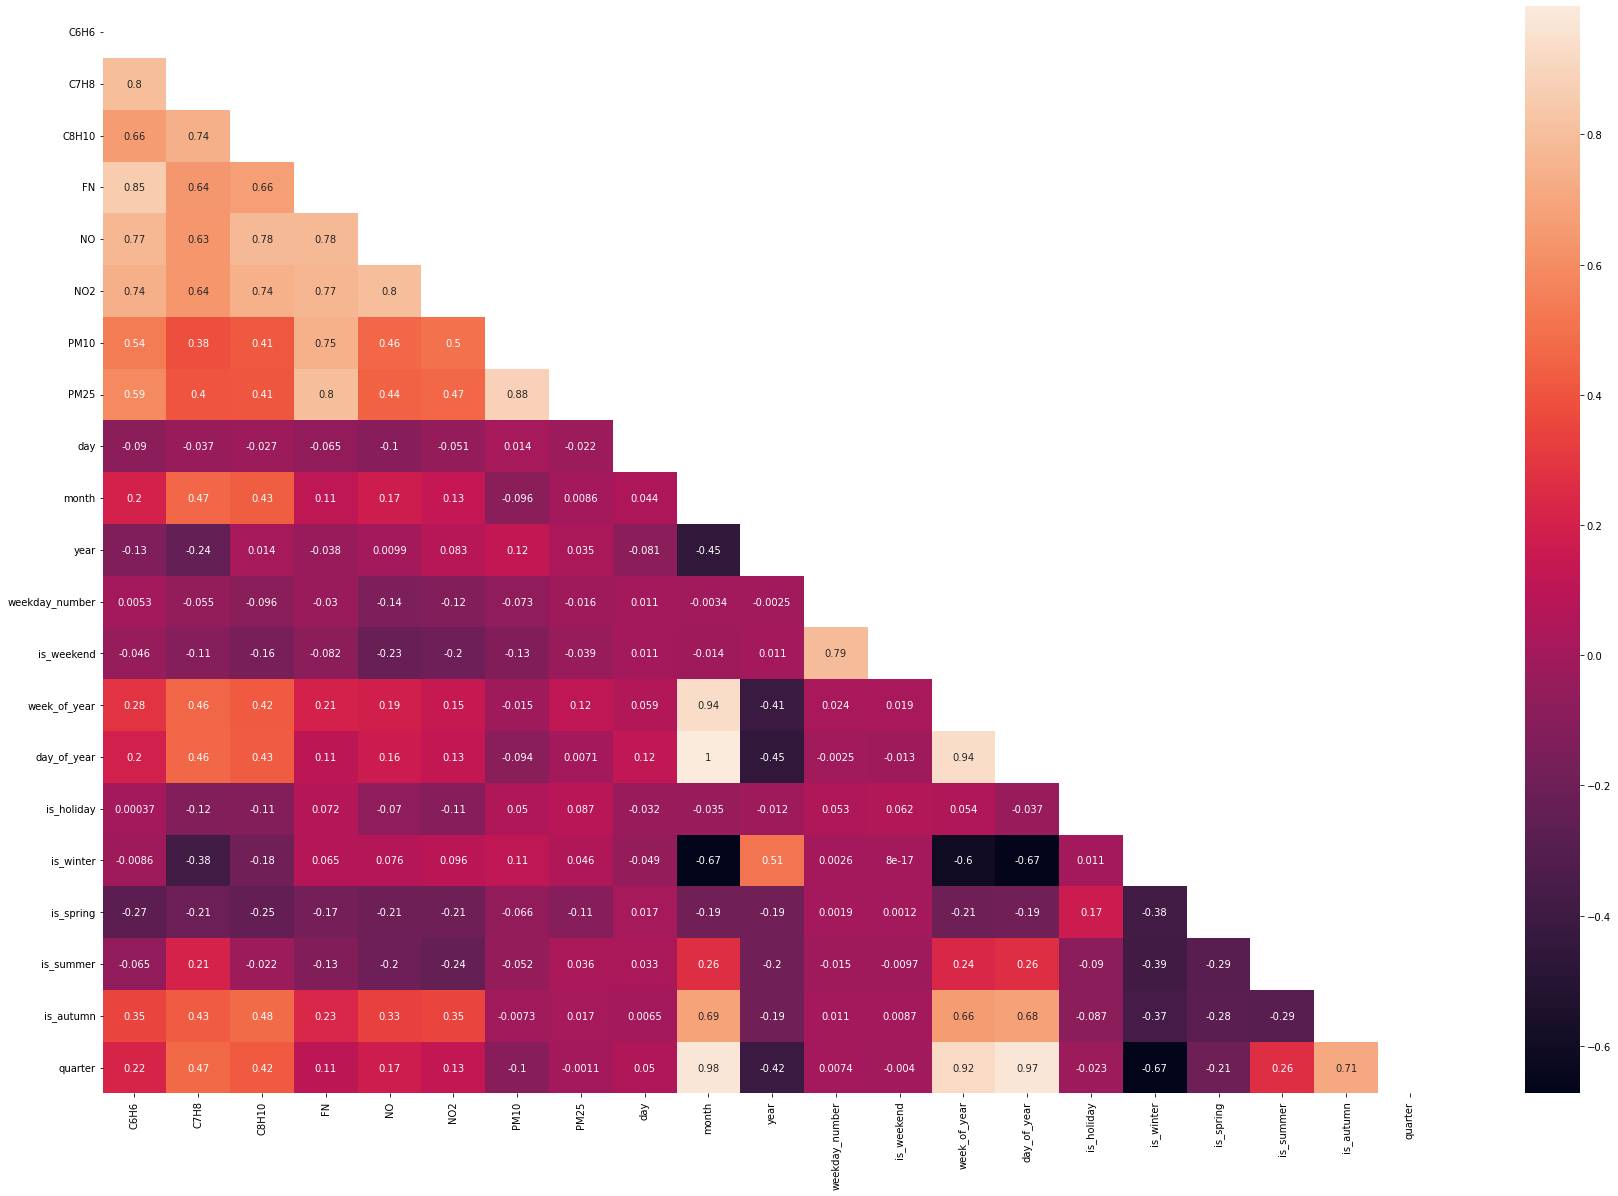

In [62]:
plt.figure(figsize=(30,20))

correlation = pivot_lagged[columns_to_lag + date_columns].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True)
plt.show()

### Correlation with lags

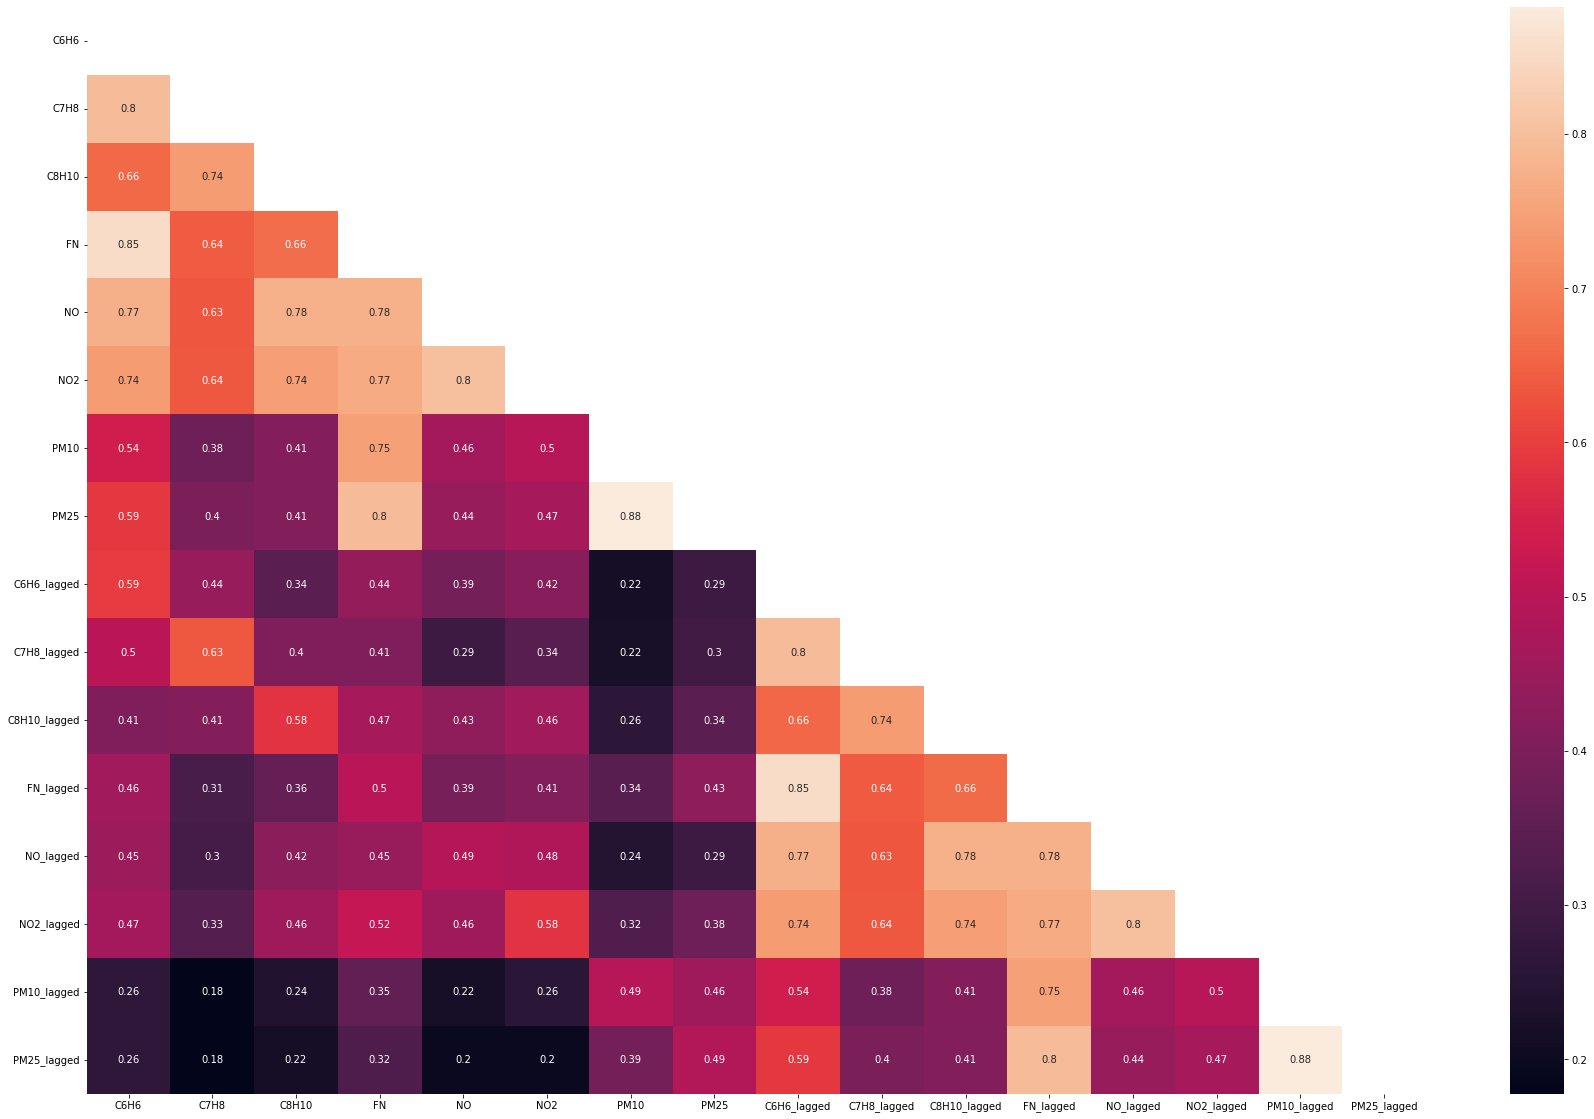

In [63]:
plt.figure(figsize=(30,20))

correlation = pivot_lagged[columns_to_lag + lag_columns].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True)
plt.show()

Below is a summary of the correlations we just calculated


| Component         | Moving averages (2 days) | Lagged values | Weather Variables | Date variables          |
|:-----------------:|:------------------------:|:-------------:|:-----------------:|:-----------------------:|
| C6H6              | C6H6, FN                 | C6H6, C7H8    | Wind speed        | is_autumn               |                       
| C7H8              | C7H8                     | C7H8, C6H6    | tmax, wind speed  | quarter, is_autumn      |  
| C8H10             | C8H10                    | C8H10         | Wind speed        | quarter, is_autumn      |
| FN                | FN, C6H6                 | FN            | Wind speed        | None                    |  
| NO                | NO                       | NO            | Wind speed        | is_autumn               |  
| NO2               | NO2                      | NO2           | Wind speed        | is_autumn               |  
| PM10              | PM10, PM25               | PM10, PM25    | Pres, prcp        | None                    |  
| PM25              | PM10, PM25               | PM10, PM25    | wpgt              | None                    |  


Since the moving average of 3 days was highly correlated with the moving average of 2 days, we chose to only use variables from the moving average of 2 days as they were the ones with the highest correlation.

### Modelling
#### Setting dataset and columns to use

In [64]:
COMPONENT = 'PM25'
train_start = '2021-01-01'
train_end = '2021-12-31'
test_start = '2022-01-01'
test_end = '2022-02-22'

train_ds = pivot_lagged[train_start:train_end]
test_ds = pivot_lagged[test_start:test_end]

train_ds = train_ds.dropna(subset=COMPONENT)
test_ds = test_ds.dropna(subset=COMPONENT)

In [65]:
columns_to_predict = {
    'C6H6': ['is_autumn', 'C6H6_lagged', 'C7H8_lagged', 'wspd', 'C6H6_moving_2_days', 'FN_moving_2_days'],
    'C7H8': ['is_autumn', 'quarter', 'C7H8_moving_2_days', 'C6H6_lagged', 'C7H8_lagged', 'tmax', 'wspd'],
    'C8H10': ['is_autumn', 'quarter', 'C8H10_moving_2_days', 'C8H10_lagged', 'wspd'],
    'FN': ['C6H6_moving_2_days', 'FN_moving_2_days', 'FN_lagged', 'wspd'],
    'NO': ['is_autumn', 'wspd', 'NO_moving_2_days', 'NO_lagged'],
    'NO2': ['is_autumn', 'wspd', 'NO2_moving_2_days', 'NO2_lagged'],
    'PM10': ['PM25_lagged', 'PM25_moving_2_days', 'PM10_moving_2_days', 'PM10_lagged', 'pres', 'prcp'],
    'PM25': ['PM25_lagged', 'PM25_moving_2_days', 'PM10_moving_2_days', 'PM10_lagged', 'wpgt'],
}
columns_to_predict_simple = ['weekday_number', 'month']

Helper functions and classes


In [66]:
def train_model(model_library, columns_to_train, prediction_column, train_ds, cross_validation=True):
    if cross_validation:
        print('Cross validating')
        parameters = {
            'learning_rate': [0.05], #so called `eta` value
            'max_depth': [6, 9],
            'n_estimators': [3, 5], 
        }
        tscv = TimeSeriesSplit(n_splits=2)
        gsearch = GridSearchCV(estimator=model_library, cv=tscv, param_grid=parameters)
        gsearch.fit(X=train_ds[columns_to_train].reset_index(drop=True), y=train_ds[prediction_column])
        return gsearch.best_estimator_
    
    model_library.fit(X=train_ds[columns_to_train].reset_index(drop=True), y=train_ds[prediction_column])
    return model_library

In [67]:
def predict_samples(ds, columns_to_use, model):
    return model.predict(ds[columns_to_use])

In [68]:
def get_errors(ds, actual_value_column, predictions):
    return mean_squared_error(ds[actual_value_column], predictions), mean_absolute_error(ds[actual_value_column], predictions) 

In [69]:
def plot_actual_prediction(results, predictions, actual_value_column):
    plt.figure(figsize=(20,6))
    results['preds'] = predictions

    plt.plot(results.index, results[actual_value_column], label='actual')
    plt.plot(results.index, results['preds'], label='predicted')
    plt.legend(loc='upper left')
    plt.title(actual_value_column)
    return plt

In [70]:
def full_analysis(model_library, columns_to_train, prediction_column, train_ds, test_ds, cross_validation=True):
    train = train_ds.dropna(subset=prediction_column)
    test = test_ds.dropna(subset=prediction_column)
    model = train_model(model_library=model_library, columns_to_train=columns_to_train, prediction_column=prediction_column, train_ds=train, cross_validation=cross_validation)
    preds = predict_samples(ds=test, columns_to_use=columns_to_train, model=model)
    mse, mae = get_errors(test, prediction_column, preds)
    results = test.copy(deep=True)
    plot = plot_actual_prediction(results=results, predictions=preds, actual_value_column=prediction_column)
    return model, preds, mse, mae, results, plot

### Vanilla model

Here we will try to train a model with just the values and the date variables. This model will inevitably fall short on its purpose but it will serve as a baseline, any model we produce from now on must beat a MAE of 6.8, otherwise we might as well just use a basic one.

Component: PM25
Columns used: ['weekday_number', 'month']
MSE:77.44734552260027 , MAE:6.875014091634778


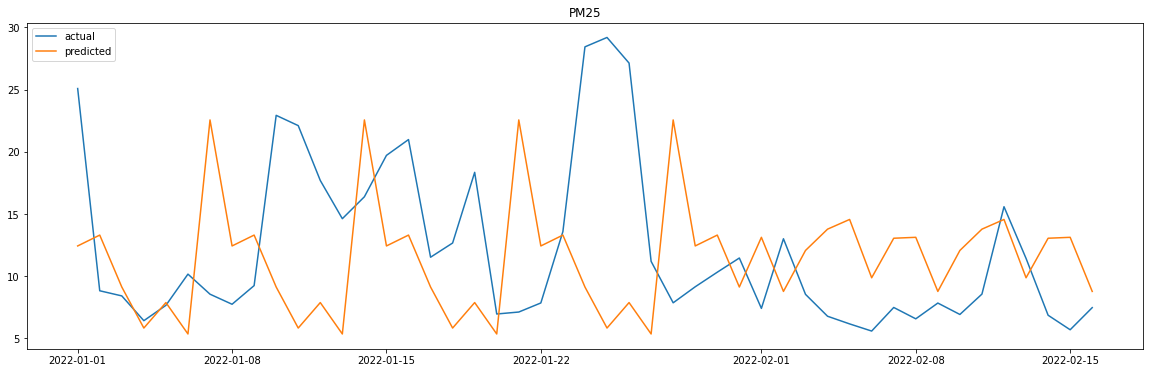

In [71]:
_, _, mse, mae, _, plot = full_analysis(model_library=XGBRegressor(), columns_to_train=columns_to_predict_simple, prediction_column=COMPONENT, train_ds=train_ds, test_ds=test_ds, cross_validation=False)
print(f'Component: {COMPONENT}')
print(f'Columns used: {columns_to_predict_simple}')
print(f'MSE:{mse} , MAE:{mae}')
plot.show()

### Add features

Component: PM25
Columns used: ['PM25_lagged', 'PM25_moving_2_days', 'PM10_moving_2_days', 'PM10_lagged', 'wpgt']
MSE:0.6455215182491283 , MAE:0.5732001074528777


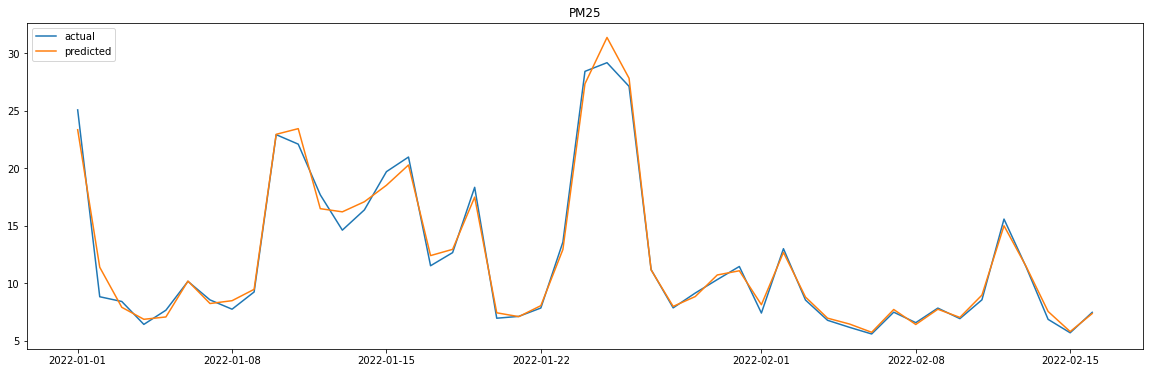

In [72]:
_, _, mse, mae, _, plot = full_analysis(model_library=XGBRegressor(), columns_to_train=columns_to_predict[COMPONENT], prediction_column=COMPONENT, train_ds=train_ds, test_ds=test_ds, cross_validation=False)
print(f'Component: {COMPONENT}')
print(f'Columns used: {columns_to_predict[COMPONENT]}')
print(f'MSE:{mse} , MAE:{mae}')
plot.show()

We can see that if we add the features we calculated the XGBoost model becomes infinitely better.

We will now train all of the components we have and output their graphs and stats.

### Train all components

Component: PM25
Columns used: ['PM25_lagged', 'PM25_moving_2_days', 'PM10_moving_2_days', 'PM10_lagged', 'wpgt']
MSE:0.6455215182491283 , MAE:0.5732001074528777


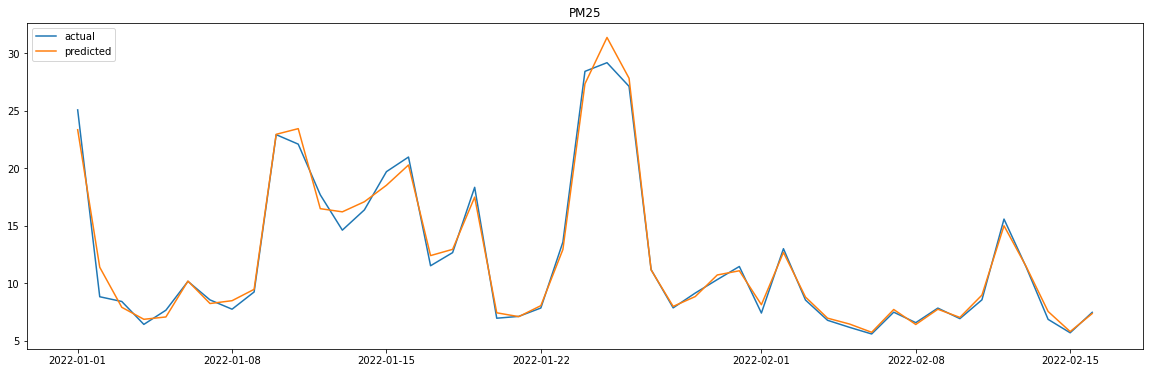

Component: PM10
Columns used: ['PM25_lagged', 'PM25_moving_2_days', 'PM10_moving_2_days', 'PM10_lagged', 'pres', 'prcp']
MSE:3.3790872471457982 , MAE:1.3016625902809336


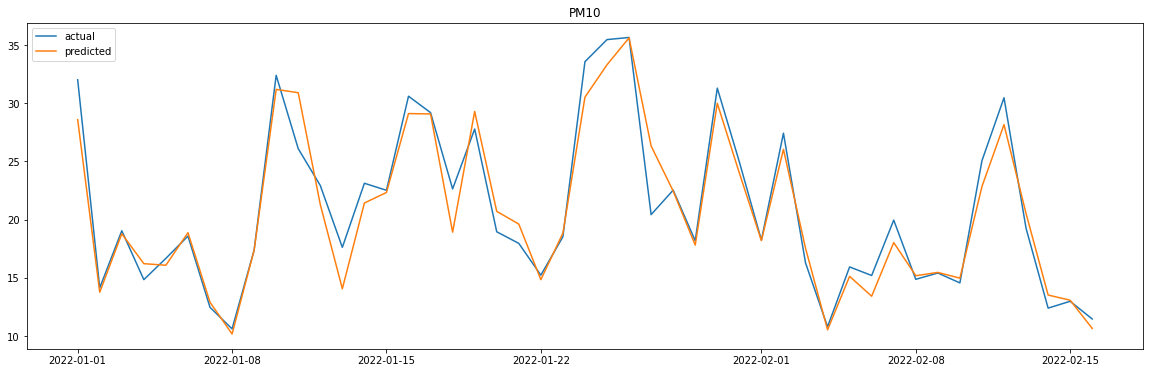

Component: FN
Columns used: ['C6H6_moving_2_days', 'FN_moving_2_days', 'FN_lagged', 'wspd']
MSE:0.011926679443512452 , MAE:0.06486740570872644


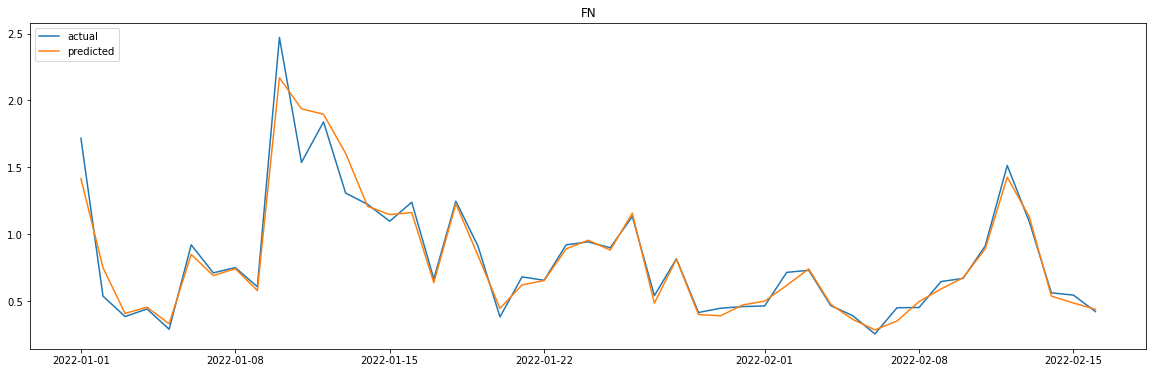

Component: C8H10
Columns used: ['is_autumn', 'quarter', 'C8H10_moving_2_days', 'C8H10_lagged', 'wspd']
MSE:0.005398435387034155 , MAE:0.05464588982195828


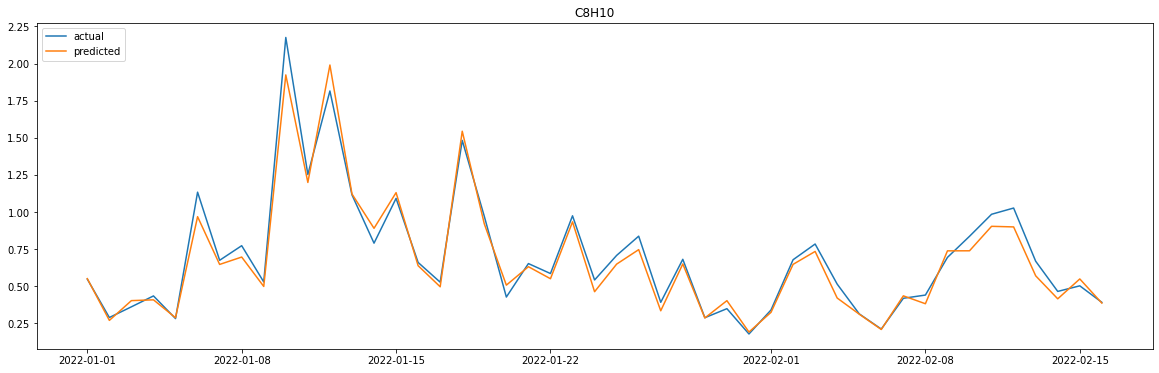

Component: C7H8
Columns used: ['is_autumn', 'quarter', 'C7H8_moving_2_days', 'C6H6_lagged', 'C7H8_lagged', 'tmax', 'wspd']
MSE:0.014914522408558083 , MAE:0.08245667829544429


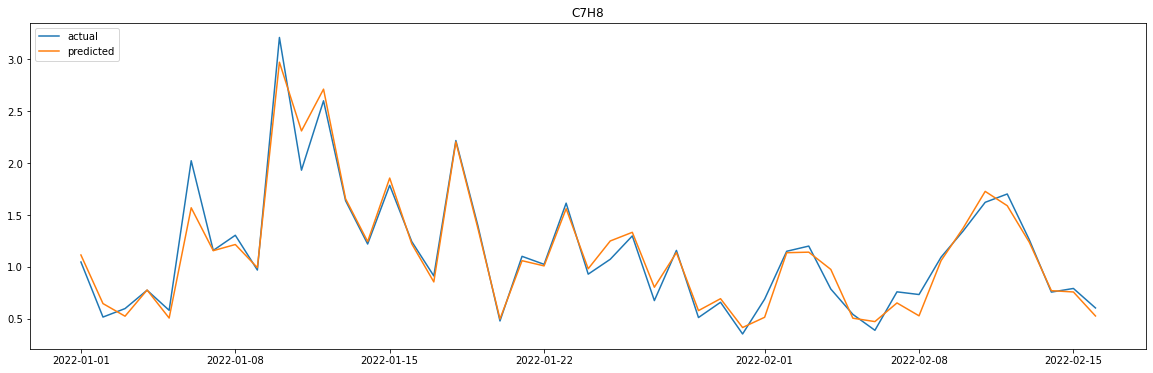

Component: C6H6
Columns used: ['is_autumn', 'C6H6_lagged', 'C7H8_lagged', 'wspd', 'C6H6_moving_2_days', 'FN_moving_2_days']
MSE:0.0007660165760346064 , MAE:0.01836837463087776


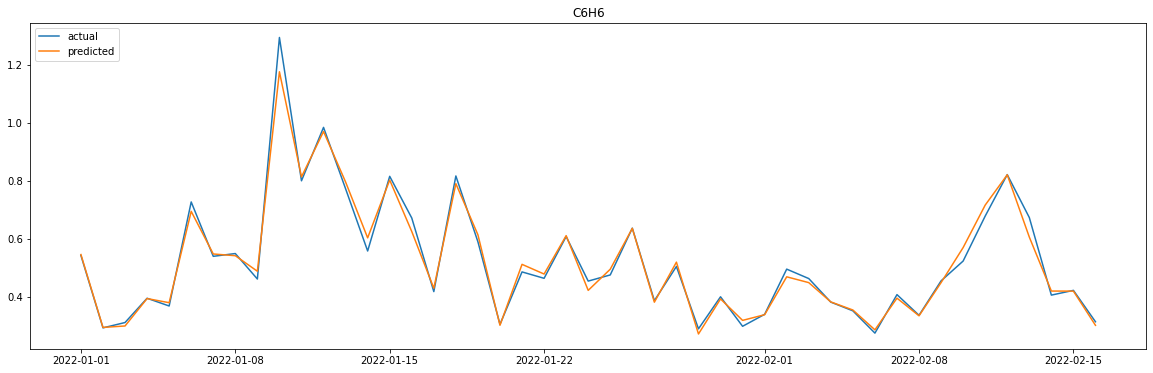

Component: NO2
Columns used: ['is_autumn', 'wspd', 'NO2_moving_2_days', 'NO2_lagged']
MSE:5.430701085320916 , MAE:1.3600773085613542


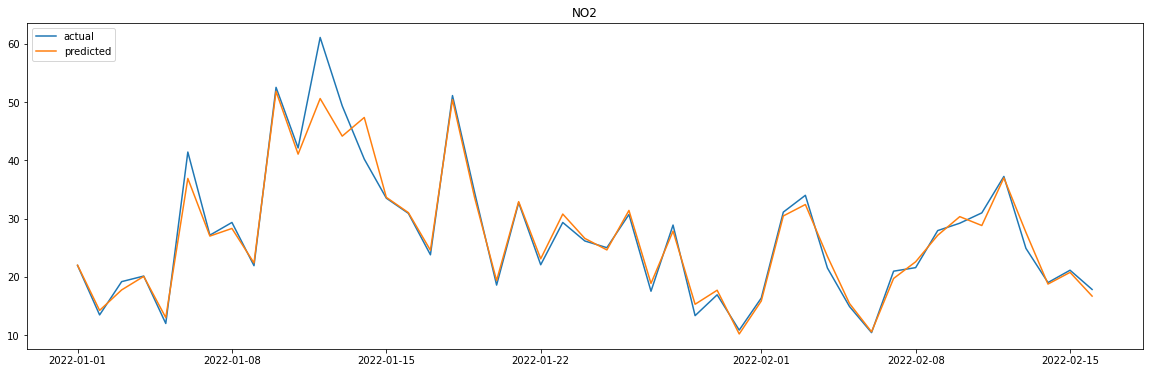

Component: NO
Columns used: ['is_autumn', 'wspd', 'NO_moving_2_days', 'NO_lagged']
MSE:1.3482742585181544 , MAE:0.7434122924506111


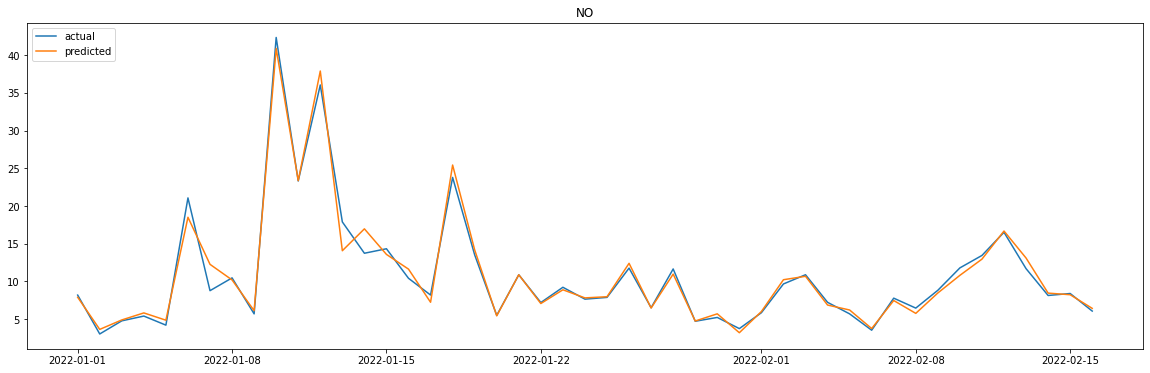

In [73]:
for component in all_components:
    _, _, mse, mae, _, plot = full_analysis(
        model_library=XGBRegressor(), 
        columns_to_train=columns_to_predict[component], 
        prediction_column=component, 
        train_ds=train_ds,
        test_ds=test_ds,
        cross_validation=False
    )
    print(f'Component: {component}')
    print(f'Columns used: {columns_to_predict[component]}')
    print(f'MSE:{mse} , MAE:{mae}')
    plot.show()

From looking at our predictions vs actual values graphs we can see that our worst performing components are the PM10 and the FN.
In general we can also see that our model can underperform in peaks (in some cases it underpredicts, in others it overpredicts).

Due to the lack of time we won't be able to actually find out why the model is doing this. But if we had it, the first step would be to run different feature combinations to see if we added or removed any interesting feature.

Another weakness of the model is that it does not take into account the actual traffic forecasts for the street, this is due to the fact that we simply could not find any dataset that had it. If such a dataset exists the model would almost certainly benefit from it.

# Alert system

Now that we have trained our model, it's time to implement our alert system.
This system would be used to send a notification that short term pollution policies would need to be put in place for that given day in order to reduce the health risks.

In [74]:
alerts = pd.DataFrame()
all_models = {}
for comp in all_components:
    model = LungProtector(component=comp)
    model.train(train_df=train_ds.dropna(subset=[comp]), columns_to_train=columns_to_predict[comp])
    predictions = model.predict(test_ds)
    to_check_limits = test_ds.copy(deep=True)
    to_check_limits['value'] = predictions
    component_alerts = model.check_values(to_check_limits)['above_maximum'].value_counts().rename_axis('alert').reset_index(name='counts')
    component_alerts['component'] = comp
    component_alerts.loc[component_alerts['alert'] == 1, 'alert'] = 'yes'
    component_alerts.loc[component_alerts['alert'] == 0, 'alert'] = 'no'
    alerts = alerts.append(component_alerts)
    all_models[comp] = model

print('Alerts for the components:')
alerts

Alerts for the components:


,alert,counts,component
0,no,34,PM25
1,yes,13,PM25
0,no,47,PM10
0,no,47,FN
0,no,47,C8H10
0,no,47,C7H8
0,no,47,C6H6
0,yes,24,NO2
1,no,23,NO2
0,no,47,NO


According to the predictions the model generated, the system would trigger a warning for PM2.5 13 times out of 47 and for NO2 24 times out of 47. 

Now let's compare it to the real values

In [75]:
alerts_real = pd.DataFrame()
for comp in all_components:
    model = all_models[comp]
    test_copy = test_ds.copy(deep=True)
    test_copy = test_copy.rename(columns={comp: 'value'})
    component_alerts = model.check_values(test_copy[['value']])['above_maximum'].value_counts().rename_axis('alert').reset_index(name='counts')
    component_alerts['component'] = comp
    component_alerts.loc[component_alerts['alert'] == 1, 'alert'] = 'yes'
    component_alerts.loc[component_alerts['alert'] == 0, 'alert'] = 'no'
    alerts_real = alerts_real.append(component_alerts)
alerts_real

,alert,counts,component
0,no,35,PM25
1,yes,12,PM25
0,no,47,PM10
0,no,47,FN
0,no,47,C8H10
0,no,47,C7H8
0,no,47,C6H6
0,no,24,NO2
1,yes,23,NO2
0,no,47,NO


We can see that our model is actually pretty close to what happened in reality when the alerts needed to be sent.
Over the month of February we would only send one false alert for the PM2.5 component and the NO2 component

## 🖼️ Visualisations

![Dashboard](https://i.ibb.co/qnRHQLS/dashboard.png)
Figure 1: Final dashboard

Our final product would be the dashboard shown above. 
It shows a line plot for each of the components and shows a red or green marker, according to the predicted value. This way, Amsterdam’s city council is able to take action based on the available forecast.  

Additionally, this dashboard and alerts can be used to bring awareness to the need of enacting long term policies to reduce air pollution.

## 👓 References

### General sources

* [WHO - Outdoor Air Quality and Health](https://www.who.int/news-room/fact-sheets/detail/ambient-%28outdoor%29-air-quality-and-health)
* [Amsterdam Clean Air Action Plan](https://www.amsterdam.nl/en/policy/sustainability/clean-air/)
* [NL Air Quality Index](https://www.luchtmeetnet.nl/informatie/luchtkwaliteit/luchtkwaliteitsindex-(lki))
* [Europe Air Quality Index](https://en.wikipedia.org/wiki/Air_quality_index#Europe)
* [Europe Air Quality Indices Definition](http://www.airqualitynow.eu/about_indices_definition.php)

### External datasets
* [Hourly air quality data in the Netherlands from 2012 to 2021](https://data.rivm.nl/data/luchtmeetnet/)
* [Weather data from 2019 to 2021](https://meteostat.net/en/)
* [Holidays data](https://pypi.org/project/holidays/)

## ⏭️ Appendix

### How does Stadhouderskade compare to other streets of Amsterdam? (Cont.)

#### NO2

In [76]:
dataset_no2 = dataset_filtered_components[dataset_filtered_components["Component"] == "NO2"]
dataset_no2_year = dataset_no2.resample("A").mean()

#### Stadhouderskade VS traffic stations

Text(0, 0.5, 'Mean Component')

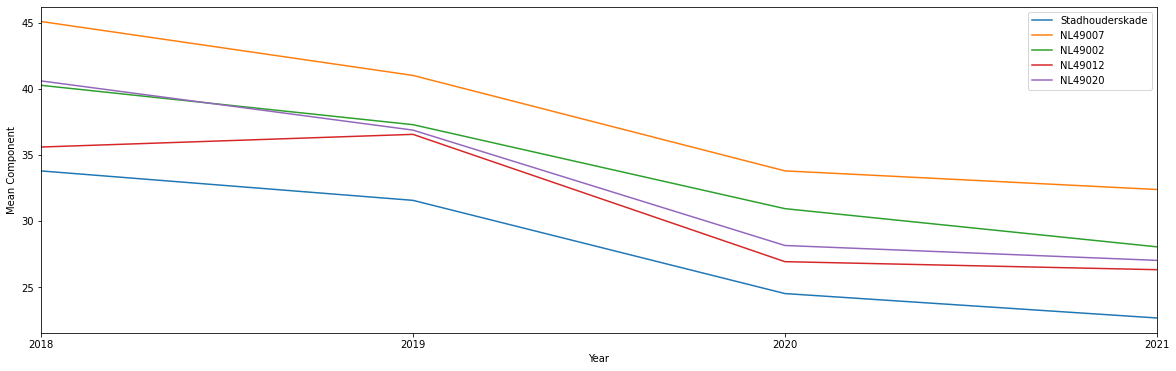

In [77]:
dataset_no2_year = dataset_no2_year.resample("A").mean()
ax = dataset_no2_year[traffic_sensors].plot(figsize=(20, 6))
ax.set_xlabel("Year")
ax.set_ylabel("Mean Component")

#### Stadhouderskade VS background stations

Text(0, 0.5, 'Mean Component')

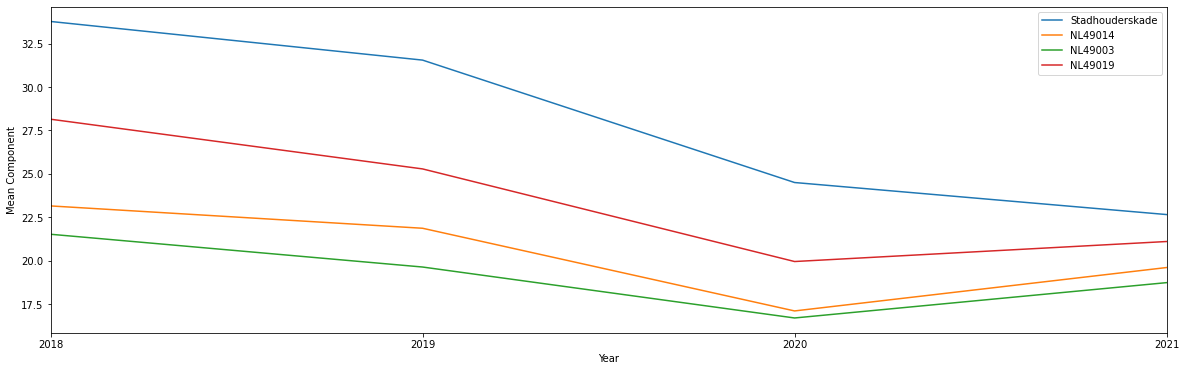

In [78]:
dataset_pm10_year = dataset_no2_year.resample("A").mean()
ax = dataset_pm10_year[background_sensors].plot(figsize=(20, 6))
ax.set_xlabel("Year")
ax.set_ylabel("Mean Component")

According to <a href=https://www.luchtmeetnet.nl/informatie/componenten/stikstofdioxide-(no2)>luchtmeet</a>, the current guideline is to prevent nitrogen dioxide to go above 40 (μg/m3) (annual mean).

The plot shows that from 2020, all the considered streets show values below the goal for the pollutant. Stadhouderskade never went above the reference value in any of the years we're taking into account.

In [79]:
dataset_no2_day = dataset_no2.resample("D").mean()

In [80]:
limit = 25

for sensor in traffic_sensors + background_sensors:
    dataset_no2_day[f'over_limit_{sensor}'] = 0
    dataset_no2_day.loc[dataset_no2_day[sensor] > limit, f'over_limit_{sensor}'] = 1

In [81]:
dataset_no2_month = dataset_no2_day[over_limit_background + over_limit_traffic].resample("Y").sum()

#### Stadhouderskade Vs traffic stations 

Text(0, 0.5, 'Mean Component')

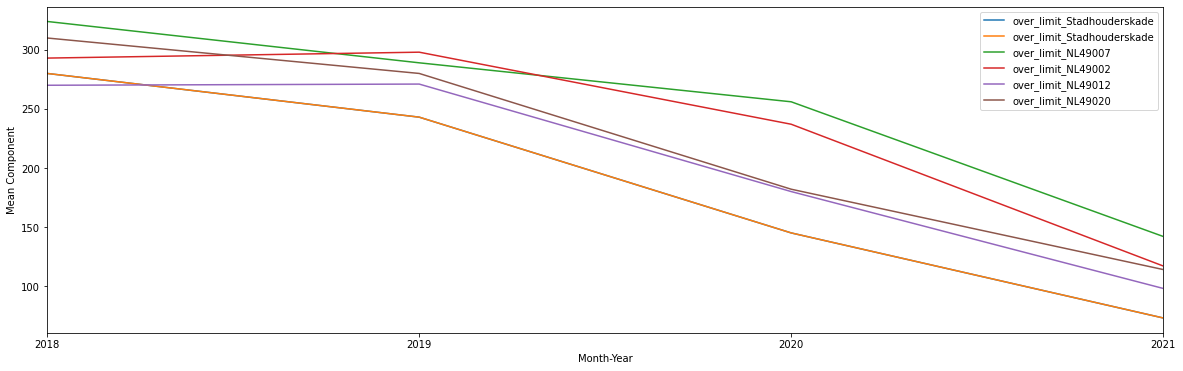

In [82]:
ax = dataset_no2_month[over_limit_traffic].plot(figsize=(20, 6))
ax.set_xlabel("Month-Year")
ax.set_ylabel("Mean Component")

#### Stadhouderskade VS background stations

Text(0, 0.5, 'Mean Component')

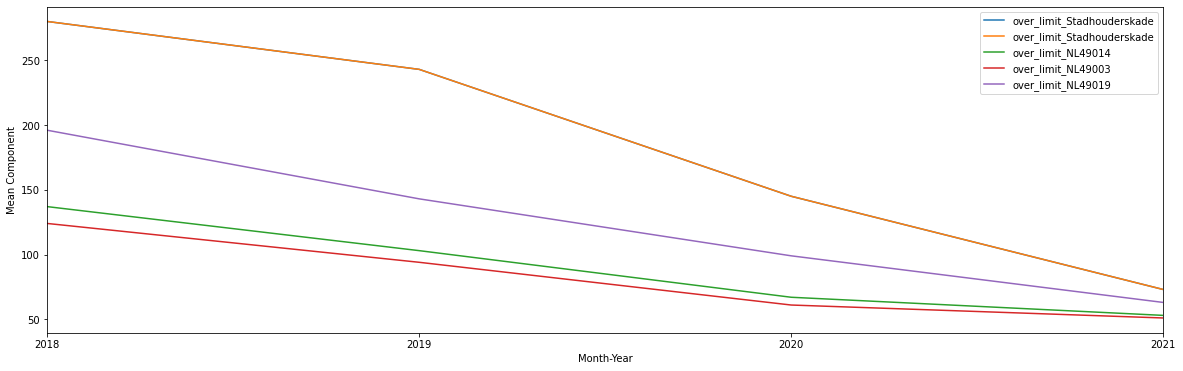

In [83]:
ax = dataset_no2_month[over_limit_background].plot(figsize=(20, 6))
ax.set_xlabel("Month-Year")
ax.set_ylabel("Mean Component")

#### PM10

In [84]:
dataset_pm10 = dataset_filtered_components[dataset_filtered_components["Component"] == "PM10"]

In [85]:
dataset_pm10_day = dataset_pm10.resample("D").mean()

In [86]:
limit = 45

for sensor in traffic_sensors + background_sensors:
    dataset_pm10_day[f'over_limit_{sensor}'] = 0
    dataset_pm10_day.loc[dataset_pm10_day[sensor] > limit, f'over_limit_{sensor}'] = 1

In [87]:
dataset_pm10_month = dataset_pm10_day[over_limit_background + over_limit_traffic].resample("Y").sum()

#### Stadhouderskade VS traffic stations

Text(0, 0.5, 'Mean Component')

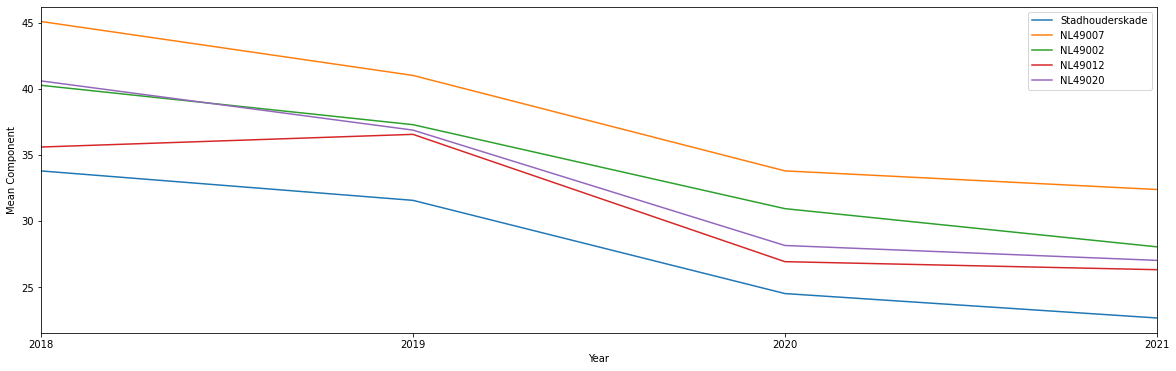

In [88]:
ax = dataset_pm10_year[traffic_sensors].plot(figsize=(20, 6))
ax.set_xlabel("Year")
ax.set_ylabel("Mean Component")

#### Stadhouderskade VS background stations

Text(0, 0.5, 'Mean Component')

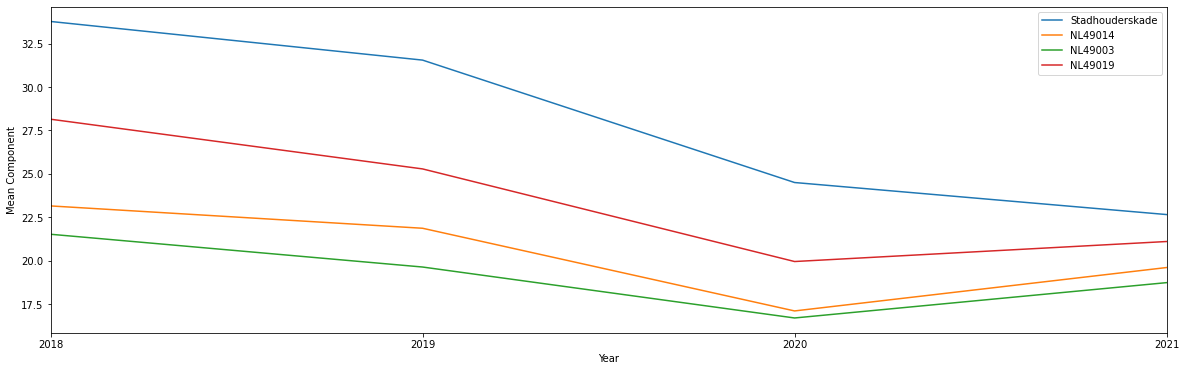

In [89]:
ax = dataset_pm10_year[background_sensors].plot(figsize=(20, 6))
ax.set_xlabel("Year")
ax.set_ylabel("Mean Component")

### Over limit

#### Stadhouderskade VS traffic stations

Text(0, 0.5, 'Mean Component')

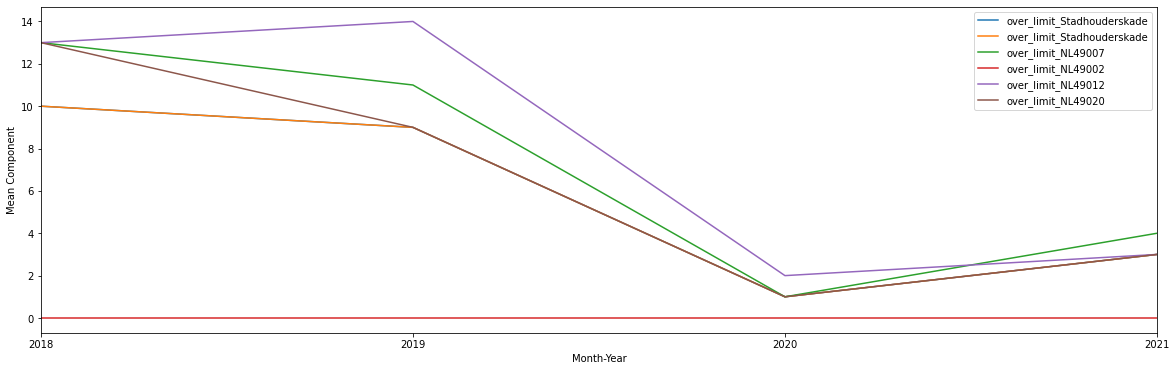

In [90]:
ax = dataset_pm10_month[over_limit_traffic].plot(figsize=(20, 6))
ax.set_xlabel("Month-Year")
ax.set_ylabel("Mean Component")

#### Stadhouderskade VS background stations

Text(0, 0.5, 'Mean Component')

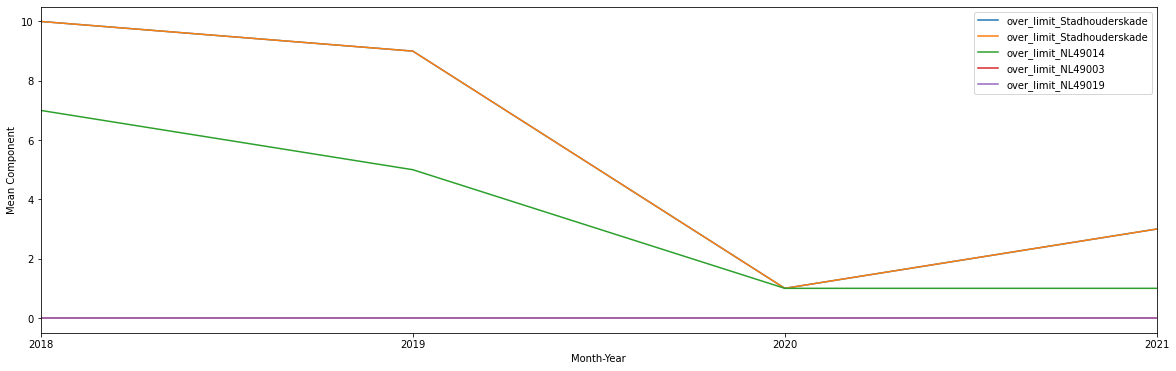

In [91]:
ax = dataset_pm10_month[over_limit_background].plot(figsize=(20, 6))
ax.set_xlabel("Month-Year")
ax.set_ylabel("Mean Component")